<a href="https://colab.research.google.com/github/VerySimo/Machine-learning/blob/main/BIENETRE_20231010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Différentes bibliothèques utilisées

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme() # pour modifier le thème
import warnings

# Ignore all warnings globally
warnings.simplefilter("ignore")

!pip install category_encoders
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

from sklearn.model_selection import GridSearchCV, train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.1 MB/s eta 0:00:00


##Documents utilisés

In [ ]:
#Document d'entraînement
df = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df = df[df["year"] != 2005]

#Document duquel seront extraites les régions
df1 = pd.read_csv(filepath_or_buffer='world-happiness-report-2021.xls')
#df1 = pd.read_csv(filepath_or_buffer='world-happiness-report-2021.csv')

#Document sur lequel nous testerons nos prédictions dans le cadre d'une cross validation
df2 = pd.read_excel("world-happiness-report-2022.xls")

In [ ]:
#Création d'un dataframe récapitulant les régions géographiques par pays
df3=pd.DataFrame()
df3['Country name']= df1['Country name']
df3['Regional indicator'] = df1['Regional indicator']
df3

,Country name,Regional indicator
0,Finland,Western Europe
1,Denmark,Western Europe
2,Switzerland,Western Europe
3,Iceland,Western Europe
4,Netherlands,Western Europe
...,...,...
144,Lesotho,Sub-Saharan Africa
145,Botswana,Sub-Saharan Africa
146,Rwanda,Sub-Saharan Africa
147,Zimbabwe,Sub-Saharan Africa


In [ ]:
nb_pays_region = df3["Regional indicator"].value_counts()


In [ ]:
"""
A la fin de la phase exploratoire, plusieurs faits questionnent :
- "generosity" semble secondaire par rapport aux autres variables ==> est-elle nécessaire ?
- les variables "Healthy", "PIB" et "social support" sont corrélées entre elles ==> est-ce un frein pour la performance de nos modèles ?
- d'un pays à un autre, les combinaisons linéaires ne sont pas les mêmes ==> Quel algorithme sera le plus adapté ? Es-ce que de la feature engineering pourrait décoder ce phénomène par la création de groupes/variables ?

Ce sera tout l'enjeu de la modélisation :
- avec un focus très important sur le pre-processing
- puis, sur la compréhension des modèles de machine learning
"""

'\nA la fin de la phase exploratoire, plusieurs faits questionnent :\n- "generosity" semble secondaire par rapport aux autres variables ==> est-elle nécessaire ?\n- les variables "Healthy", "PIB" et "social support" sont corrélées entre elles ==> est-ce un frein pour la performance de nos modèles ?\n- d\'un pays à un autre, les combinaisons linéaires ne sont pas les mêmes ==> Quel algorithme sera le plus adapté ? Es-ce que de la feature engineering pourrait décoder ce phénomène par la création de groupes/variables ?\n\nCe sera tout l\'enjeu de la modélisation :\n- avec un focus très important sur le pre-processing\n- puis, sur la compréhension des modèles de machine learning\n'

##Pré-processing

In [ ]:
"""
Le pré-processing est la partie la plus importante du machine learning, sans lequel nos modèles ne pourraient pas marcher.

L'enjeu de cette première partie va être de :
- déterminer le meilleur encodage
- veiller à la gestion des Nan qui sont significatifs dans notre jeu de données
- choisir les bonnes variables

Dans un premier temps, nous partirons sur un modèle et un paramétrage très standards pour mettre en place une procédure d'évaluation avec des métriques adaptées.
Dans un second temps, à partir du même modèle, nous lancerons plusieurs scenario de pré-processing pour réfuter ou confirmer certains paramétrages.
"""

"\nLe pré-processing est la partie la plus importante du machine learning, sans lequel nos modèles ne pourraient pas marcher.\n\nL'enjeu de cette première partie va être de :\n- déterminer le meilleur encodage\n- veiller à la gestion des Nan qui sont significatifs dans notre jeu de données\n- choisir les bonnes variables\n\nDans un premier temps, nous partirons sur un modèle et un paramétrage très standards pour mettre en place une procédure d'évaluation avec des métriques adaptées.\nDans un second temps, à partir du même modèle, nous lancerons plusieurs scenario de pré-processing pour réfuter ou confirmer certains paramétrages.\n"

###Choix de la métrique

In [ ]:
"""
Quand à la métrique à prendre considération, nous pensons qu'il est important, sur ce jeu de données, de limiter les grosses erreurs.
En fait, l'échelle de valeurs de notre variable cible va de 0 à 10 et sont exprimées avec 3 chiffres après la virgule.
Nous avons donc considérer que des erreurs de plus de 1 devenaient vite problématiques.

De ce fait, 3 métriques seront comparées entre elles :
- la MAE qui ne pénalise pas les grosses, mais nous informe du pourcentage d'erreurs sur l'ensemble des prédiction
- la RSME qui accentue les grosses erreurs
"""

"\nQuand à la métrique à prendre considération, nous pensons qu'il est important, sur ce jeu de données, de limiter les grosses erreurs.\nEn fait, l'échelle de valeurs de notre variable cible va de 0 à 10 et sont exprimées avec 3 chiffres après la virgule.\nNous avons donc considérer que des erreurs de plus de 1 devenaient vite problématiques.\n\nDe ce fait, 3 métriques seront comparées entre elles :\n- la MAE qui ne pénalise pas les grosses, mais nous informe du pourcentage d'erreurs sur l'ensemble des prédiction\n- la RSME qui accentue les grosses erreurs\n"

###Première modélisation

In [ ]:
"""
L'arbre de décision n'est pas sensible aux formats des cellules numériques.
Pour ce premier test, nous allons lancer un modèle simple, avec peu de paramétrages :
- Suppression générale des Nan
- Train-test-split standard 80%-20%.
- Random_state afin de pouvoir comparer les résultats entre différentes exécutions

L'objectif est d'avoir une idée des performances du modèle avec le strict minimum.
"""

"\nL'arbre de décision n'est pas sensible aux formats des cellules numériques.\nPour ce premier test, nous allons lancer un modèle simple, avec peu de paramétrages :\n- Suppression générale des Nan\n- Train-test-split standard 80%-20%.\n- Random_state afin de pouvoir comparer les résultats entre différentes exécutions\n\nL'objectif est d'avoir une idée des performances du modèle avec le strict minimum.\n"

####Test n°1


In [ ]:
df_1 = df.dropna(axis = 0, how = "any")

In [ ]:
df_1.isna().sum().sum()

0

In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_1['Life Ladder']
X = df_1.drop(["Life Ladder", "Country name", "year"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1365, 8)
(342, 8)


In [ ]:
#Entraînement du modèle
from sklearn.tree import DecisionTreeRegressor
tree_regressor_V1 = DecisionTreeRegressor(random_state=42)
tree_regressor_V1.fit(X_train, y_train)

#Performance entre le train et le test
print("score train : " , tree_regressor_V1.score(X_train, y_train))
print("score test : ", tree_regressor_V1.score(X_test,y_test))


score train :  1.0
score test :  0.7580666080829626


In [ ]:
# Prédictions des valeurs sur l'ensemble de test
y_pred = tree_regressor_V1.predict(X_test)

#calcul des différents métriques
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE :", mean_squared_error(y_test, y_pred, squared = False))

MAE : 0.39411111111111113
RMSE : 0.550620373144363


In [ ]:
"""
Malgré le sur-apprentissage, le score est correct
==> cela est révélateur d'un jeu de données assez propre et que le principal challenge sera de trouver les bons réglages pour le généraliser.
==> la diminution du jeu d'entraînement a été testée et au-delà du fait que les scores se dégradent, l'over-fitting n'est pas résolu.
==> à cette étape du pré-processing, nous fixons le split train / test à 80-20
"""

"\nMalgré le sur-apprentissage, le score est correct\n==> cela est révélateur d'un jeu de données assez propre et que le principal challenge sera de trouver les bons réglages pour le généraliser.\n==> la diminution du jeu d'entraînement a été testée et au-delà du fait que les scores se dégradent, l'over-fitting n'est pas résolu.\n==> à cette étape du pré-processing, nous fixons le split train / test à 80-20\n"

####Importances des variables sous forme de plot

<Axes: >

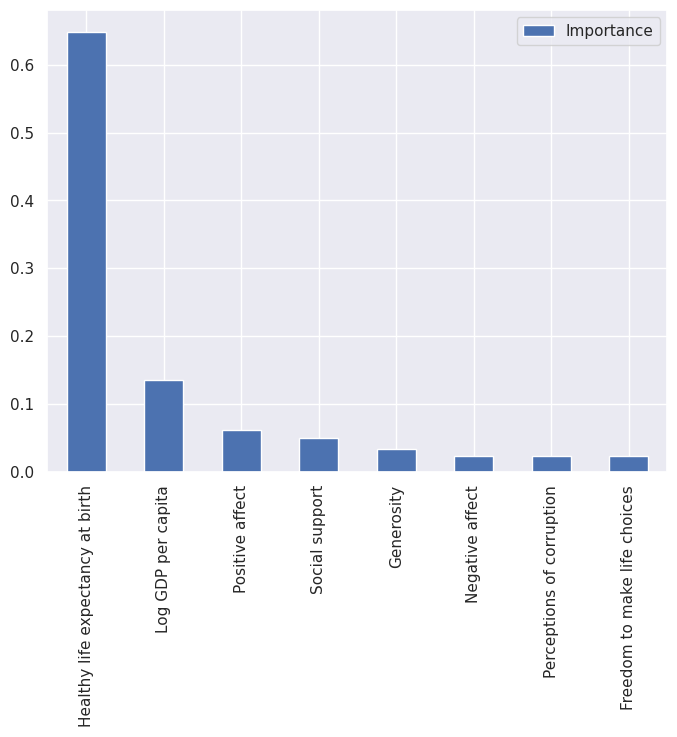

In [ ]:
#Importance des variables sous forme de plot

import matplotlib.pyplot as plt
%matplotlib inline
feat_importances = pd.DataFrame(tree_regressor_V1.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

####Arbre de décision

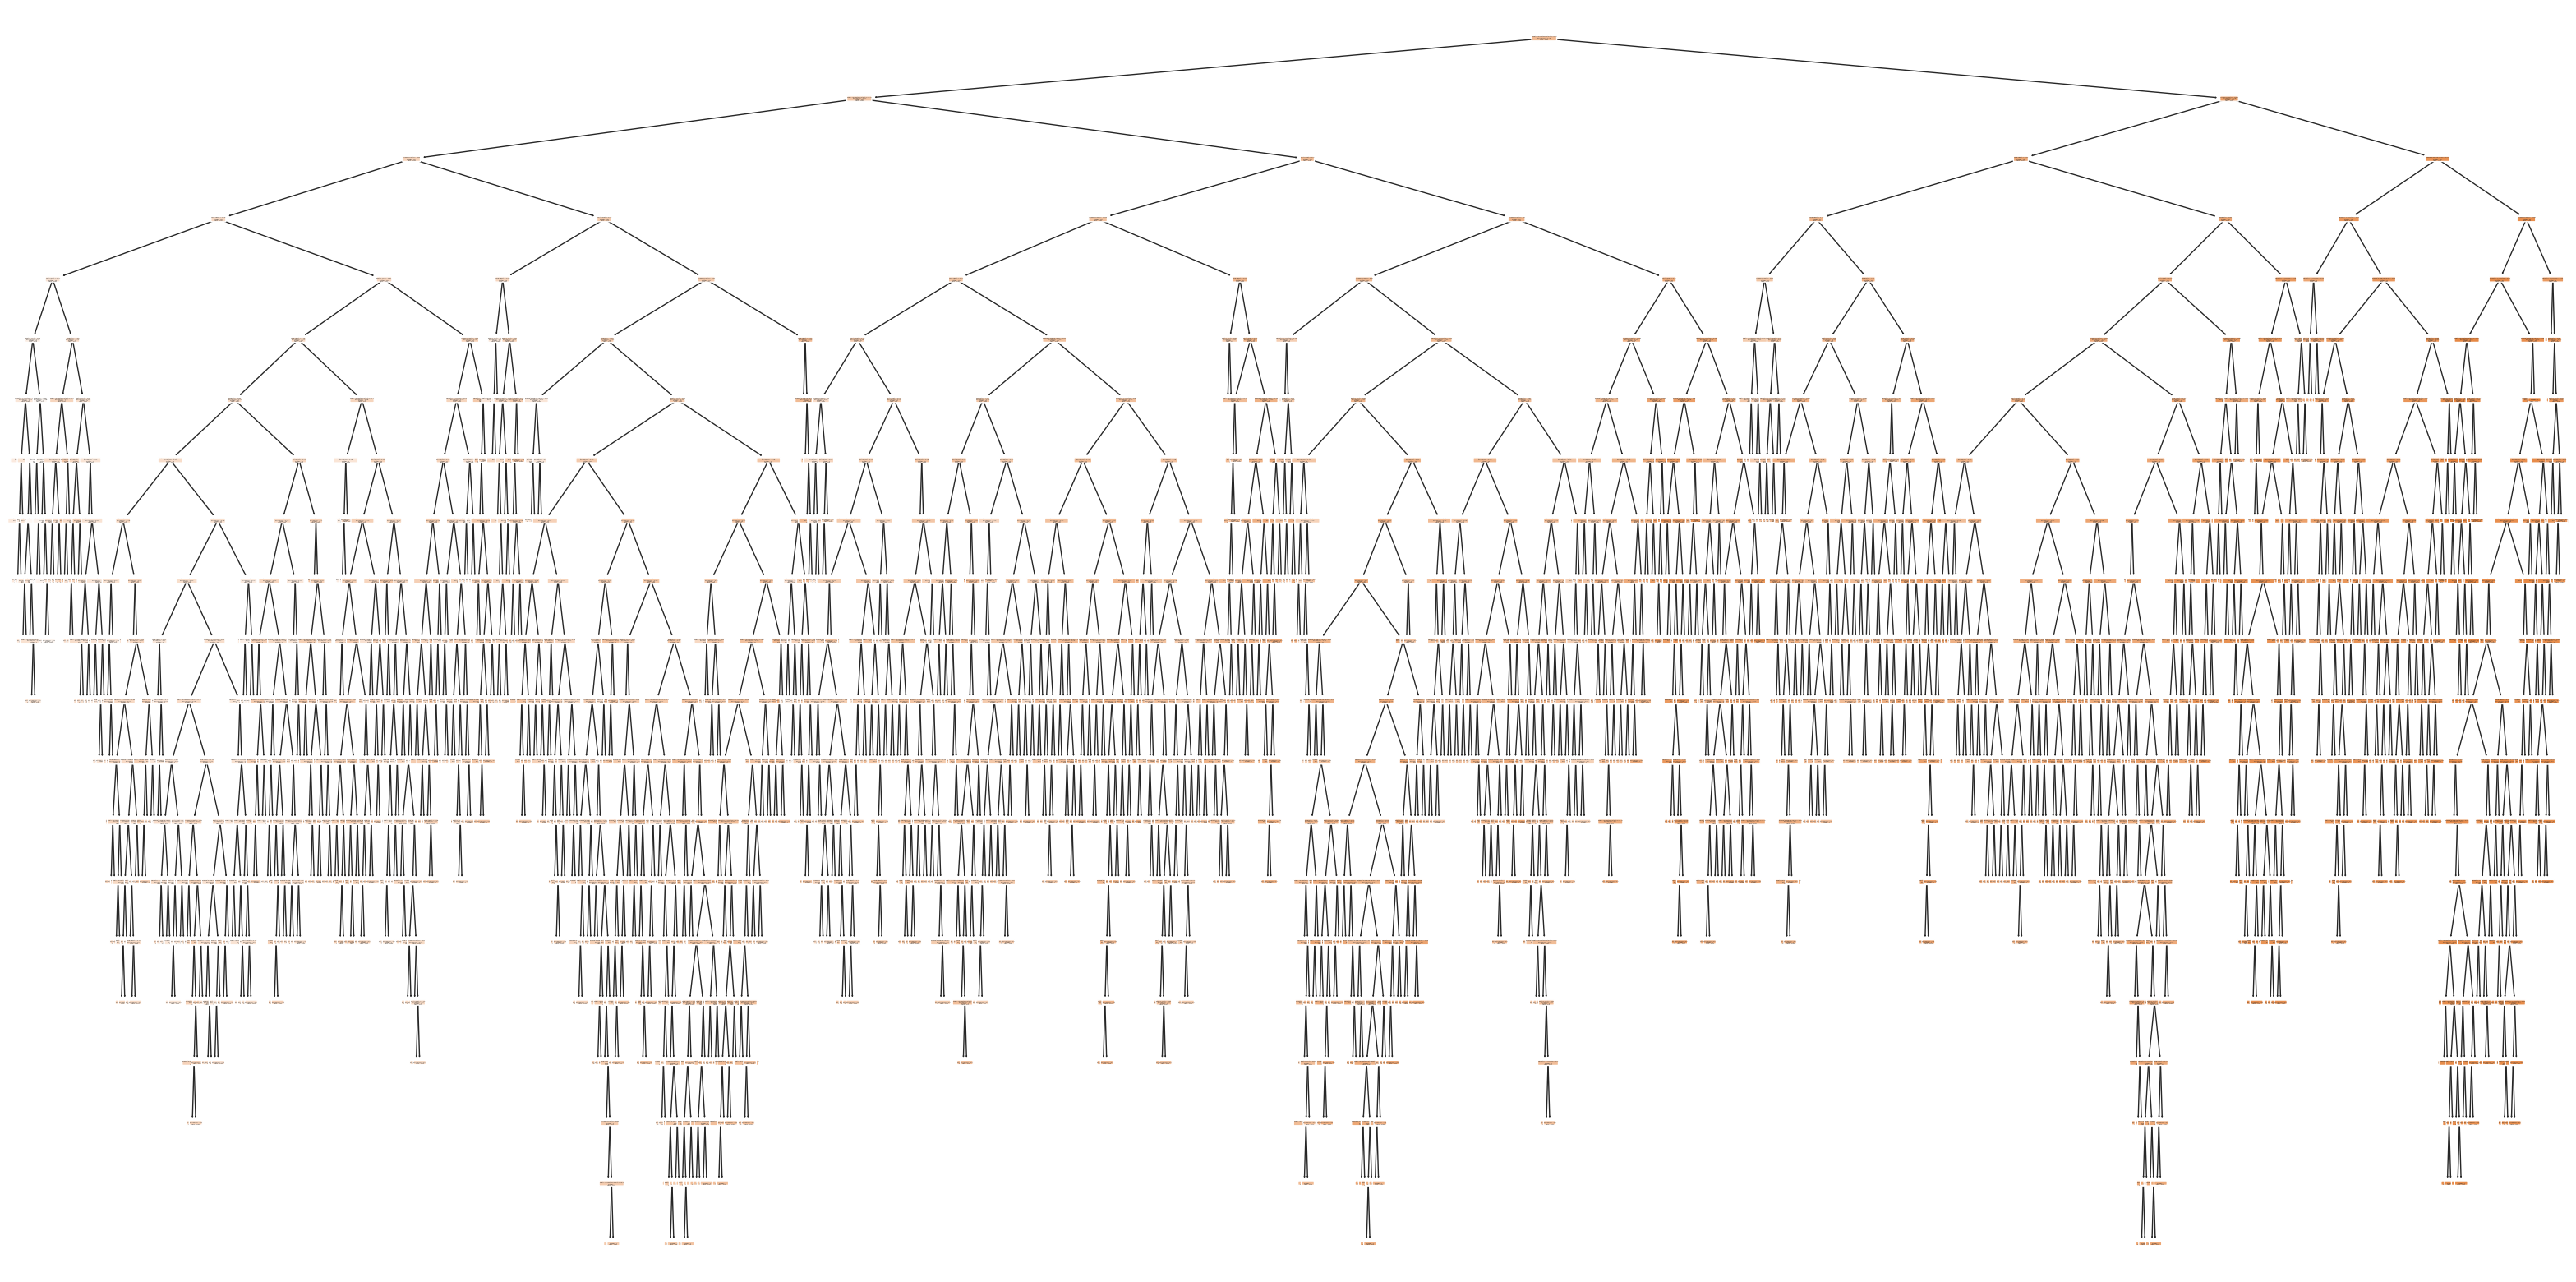

In [ ]:
#Affichage de l'arbre de décision

from sklearn.tree import DecisionTreeRegressor
min_samples = DecisionTreeRegressor(random_state=42)
min_samples.fit(X_train, y_train)

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(40, 20))

plot_tree(min_samples,
          feature_names=X_train.columns,
          filled=True,
          rounded=True)

plt.show()

In [ ]:
from sklearn.tree import export_text
tree_rules = export_text(min_samples, feature_names=list(X_train.columns))
print(tree_rules)


|--- Healthy life expectancy at birth <= 67.26
|   |--- Healthy life expectancy at birth <= 60.56
|   |   |--- Log GDP per capita <= 8.06
|   |   |   |--- Social support <= 0.53
|   |   |   |   |--- Positive affect <= 0.59
|   |   |   |   |   |--- Negative affect <= 0.37
|   |   |   |   |   |   |--- Perceptions of corruption <= 0.82
|   |   |   |   |   |   |   |--- Perceptions of corruption <= 0.80
|   |   |   |   |   |   |   |   |--- Freedom to make life choices <= 0.69
|   |   |   |   |   |   |   |   |   |--- value: [3.33]
|   |   |   |   |   |   |   |   |--- Freedom to make life choices >  0.69
|   |   |   |   |   |   |   |   |   |--- value: [3.33]
|   |   |   |   |   |   |   |--- Perceptions of corruption >  0.80
|   |   |   |   |   |   |   |   |--- value: [3.19]
|   |   |   |   |   |   |--- Perceptions of corruption >  0.82
|   |   |   |   |   |   |   |--- Healthy life expectancy at birth <= 51.86
|   |   |   |   |   |   |   |   |--- Negative affect <= 0.26
|   |   |   |   |   |  

###Encodage des variables catégorielles

In [ ]:
"""
Le OneHotEncoder ne fonctionne pas. Avec un split aléatoire, nous n'avons pas toutes les modalités "pays" dans notre jeu de données.
Nous avons tenté d'autres pistes :
- augmenter le volume du jeu d'entraînement
- trier sur les années les plus complètes 2018 et autres
==> ça ne fonctionne pas

Piste privilégiée : TargetEncoder
"""

'\nLe OneHotEncoder ne fonctionne pas. Avec un split aléatoire, nous n\'avons pas toutes les modalités "pays" dans notre jeu de données.\nNous avons tenté d\'autres pistes :\n- augmenter le volume du jeu d\'entraînement\n- trier sur les années les plus complètes 2018 et autres\n==> ça ne fonctionne pas\n\nPiste privilégiée : TargetEncoder\n'

####Test n°2 - augmenter l'espace d'entraînement ==> KO

In [ ]:
df_2 = df_1.sort_values("year", ascending = False)
df_2.isna().sum()

Country name                        0
year                                0
Life Ladder                         0
Log GDP per capita                  0
Social support                      0
Healthy life expectancy at birth    0
Freedom to make life choices        0
Generosity                          0
Perceptions of corruption           0
Positive affect                     0
Negative affect                     0
dtype: int64

In [ ]:
len(df_1["Country name"].unique())

155

In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_2 ['Life Ladder']
X = df_2.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = False, random_state = 42)

In [ ]:
liste1 = X_train["Country name"].unique()
liste2 = X_test["Country name"].unique()
differences = list(set(liste1) - set(liste2))
print(differences)

['Syria', 'Gabon', 'Congo (Kinshasa)', 'Morocco', 'Saudi Arabia', 'Burundi', 'Ivory Coast', 'Suriname', 'Egypt', 'United States', 'Djibouti', 'Gambia', 'Qatar', 'Afghanistan', 'Bhutan', 'Angola', 'Myanmar', 'Madagascar', 'Cambodia', 'Iceland', 'Swaziland', 'Libya', 'Algeria', 'Malta', 'Iraq', 'Congo (Brazzaville)', 'Tunisia', 'Yemen', 'Rwanda', 'Mauritius', 'Canada', 'Sudan', 'Comoros', 'Lesotho', 'Ethiopia', 'Bahrain', 'Luxembourg', 'Guinea']


####Test n°2 - trier sur l'année 2018 ==> pas suffisant

####Test n°2a - encodage des 2 variables

In [ ]:
#Import
df = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df = df[df["year"] != 2005]
df_1 = df.dropna(axis = 0, how = "any")
df_2c = df_1.sort_values(by = "year", ascending = False)

In [ ]:
df_2c.isna().sum()

Country name                        0
year                                0
Life Ladder                         0
Log GDP per capita                  0
Social support                      0
Healthy life expectancy at birth    0
Freedom to make life choices        0
Generosity                          0
Perceptions of corruption           0
Positive affect                     0
Negative affect                     0
dtype: int64

In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_2c ['Life Ladder']
X = df_2c.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)

#Encodage "Pays"
variable_cat1 = ["Country name"]

# Créer un DataFrame temporaire avec X_train et y_train
temp_df = pd.concat([X_train, y_train], axis=1)

# Calculer la moyenne de 'Life Ladder' pour chaque modalité dans l'ensemble d'entraînement
mean_encoding_map1 = temp_df.groupby(variable_cat1)['Life Ladder'].mean().to_dict()

for variable in variable_cat1:
    X_train[variable + '_encoded'] = X_train[variable].map(mean_encoding_map1)

for variable in variable_cat1:
    X_test[variable + '_encoded'] = X_test[variable].map(mean_encoding_map1)

#Encodage "Année"
def encodage_year(X):
    dico_annee = {a:b for a, b in zip(range(2006, 2099), range(1,94))}
    X["year"] = X["year"].replace(dico_annee)
    return X

X_train = encodage_year(X_train)
X_test = encodage_year(X_test)

X_train_encoder = X_train.drop(["Country name"], axis =1)
X_test_encoder = X_test.drop(["Country name"], axis =1)

In [ ]:
X_train_encoder.isna().sum()

year                                0
Log GDP per capita                  0
Social support                      0
Healthy life expectancy at birth    0
Freedom to make life choices        0
Generosity                          0
Perceptions of corruption           0
Positive affect                     0
Negative affect                     0
Country name_encoded                0
dtype: int64

In [ ]:
X_test_encoder.isna().sum()

year                                0
Log GDP per capita                  0
Social support                      0
Healthy life expectancy at birth    0
Freedom to make life choices        0
Generosity                          0
Perceptions of corruption           0
Positive affect                     0
Negative affect                     0
Country name_encoded                0
dtype: int64

In [ ]:
# Entraînement du modèle
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
tree_regressor_V2= DecisionTreeRegressor(random_state=42)
tree_regressor_V2.fit(X_train_encoder, y_train)

# Performance entre le train et le test
print("score train : " , tree_regressor_V2.score(X_train_encoder, y_train))
print("score test : ", tree_regressor_V2.score(X_test_encoder,y_test))


score train :  1.0
score test :  0.8525013736484575


In [ ]:
# Prédictions des valeurs sur l'ensemble de test
y_pred = tree_regressor_V2.predict(X_test_encoder)

#calcul des différents métriques
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE :", mean_squared_error(y_test, y_pred, squared = False))

MAE : 0.31930701754385965
RMSE : 0.42860150319149803


In [ ]:
"""
Score plus performants
"""

'\nScore plus performants\n'

Text(0.5, 1.0, "Ordre d'importance des variables explicatives")

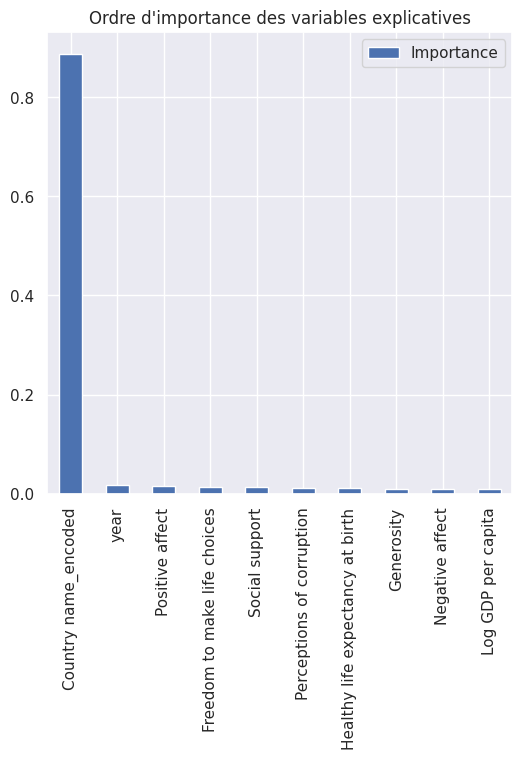

In [ ]:
#Importance des variables sous forme de plot

import matplotlib.pyplot as plt
%matplotlib inline
feat_importances = pd.DataFrame(tree_regressor_V2.feature_importances_, index=X_train_encoder.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(6,6))
plt.title("Ordre d'importance des variables explicatives")

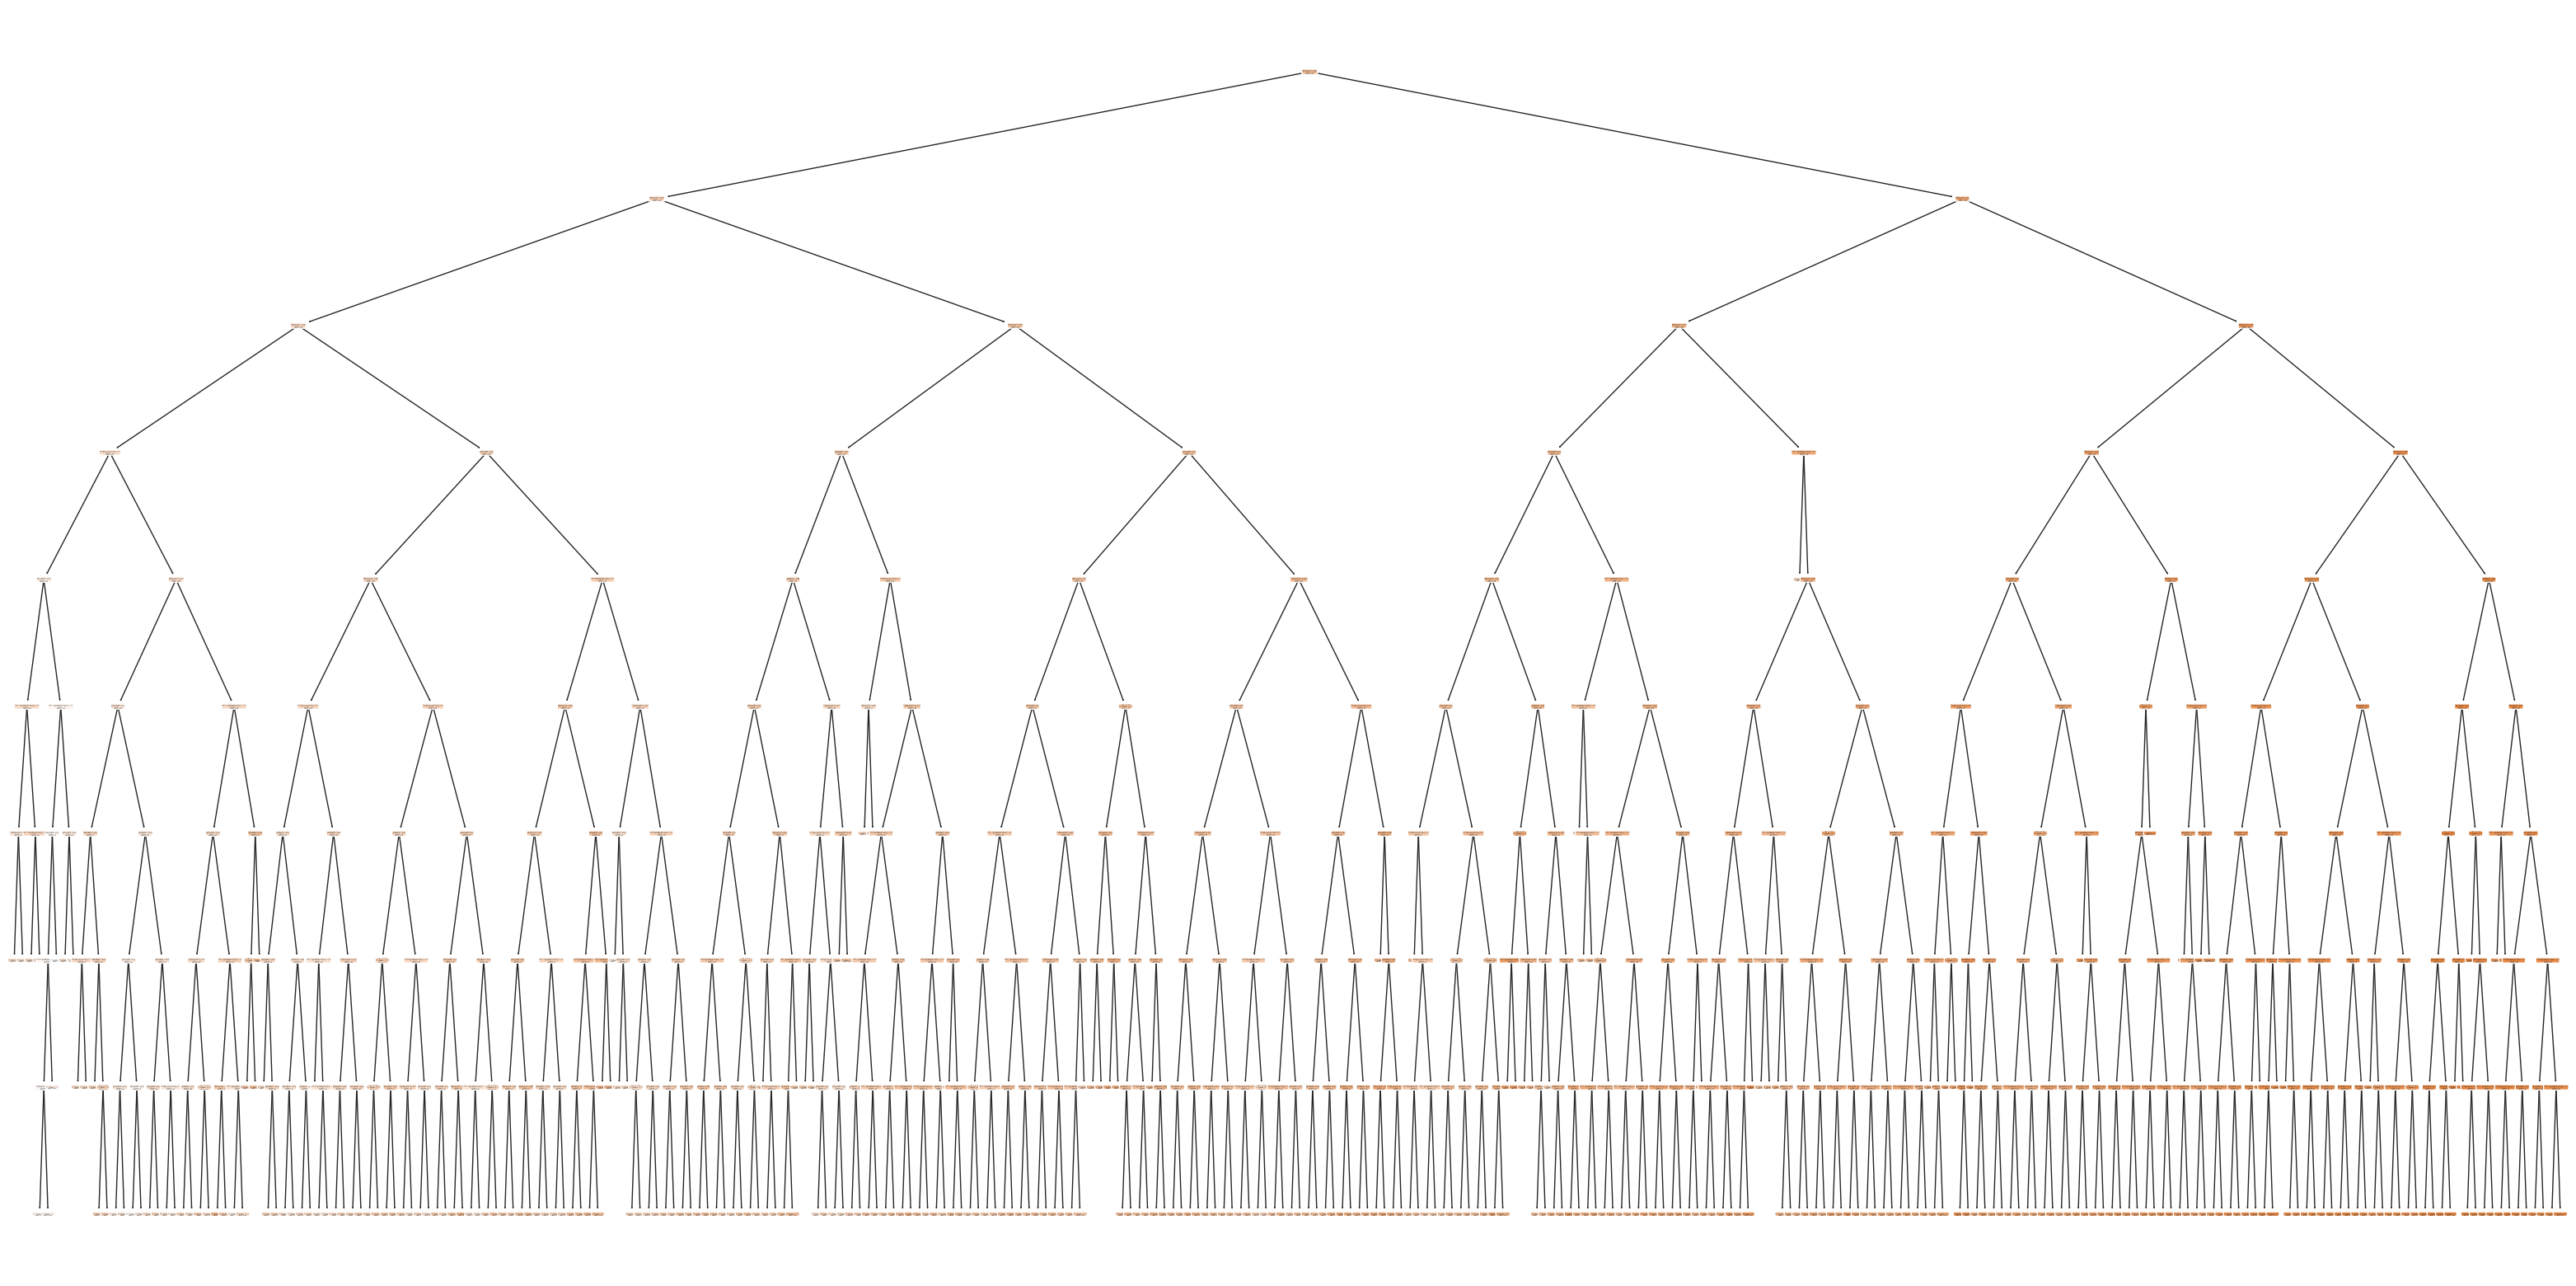

In [ ]:
#Affichage de l'arbre de décision

from sklearn.tree import DecisionTreeRegressor
min_samples = DecisionTreeRegressor(random_state=42, max_depth = 9)
min_samples.fit(X_train_encoder, y_train)

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(40, 20))

plot_tree(min_samples,
          feature_names=X_train.columns,
          filled=True,
          rounded=True)

plt.show()

####Test n°2b - encodage sans année

In [ ]:
#Import
df = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df = df[df["year"] != 2005]
df_1 = df.dropna(axis = 0, how = "any")
df_2d = df_1.sort_values(by = "year", ascending = False)
df_2d = df_2d.drop("year", axis = 1)

# Division des données en ensembles d'entraînement et de test
y = df_2d ['Life Ladder']
X = df_2d.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Encodage "Pays"
variable_cat1 = ["Country name"]

# Créer un DataFrame temporaire avec X_train et y_train
temp_df = pd.concat([X_train, y_train], axis=1)

# Calculer la moyenne de 'Life Ladder' pour chaque modalité dans l'ensemble d'entraînement
mean_encoding_map1 = temp_df.groupby(variable_cat1)['Life Ladder'].mean().to_dict()

for variable in variable_cat1:
    X_train[variable + '_encoded'] = X_train[variable].map(mean_encoding_map1)

for variable in variable_cat1:
    X_test[variable + '_encoded'] = X_test[variable].map(mean_encoding_map1)

X_train_encoder_V2 = X_train.drop(["Country name"], axis =1)
X_test_encoder_V2 = X_test.drop(["Country name"], axis =1)

In [ ]:
# Entraînement du modèle
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
tree_regressor_V3= DecisionTreeRegressor(random_state=42)
tree_regressor_V3.fit(X_train_encoder_V2, y_train)

# Performance entre le train et le test
print("score train : " , tree_regressor_V3.score(X_train_encoder_V2, y_train))
print("score test : ", tree_regressor_V3.score(X_test_encoder_V2,y_test))

score train :  1.0
score test :  0.8521706910502241


In [ ]:
# Prédictions des valeurs sur l'ensemble de test
y_pred = tree_regressor_V3.predict(X_test_encoder_V2)

#calcul des différents métriques
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE :", mean_squared_error(y_test, y_pred, squared = False))

MAE : 0.3108567251461989
RMSE : 0.4290816829500822


<Figure size 800x600 with 0 Axes>

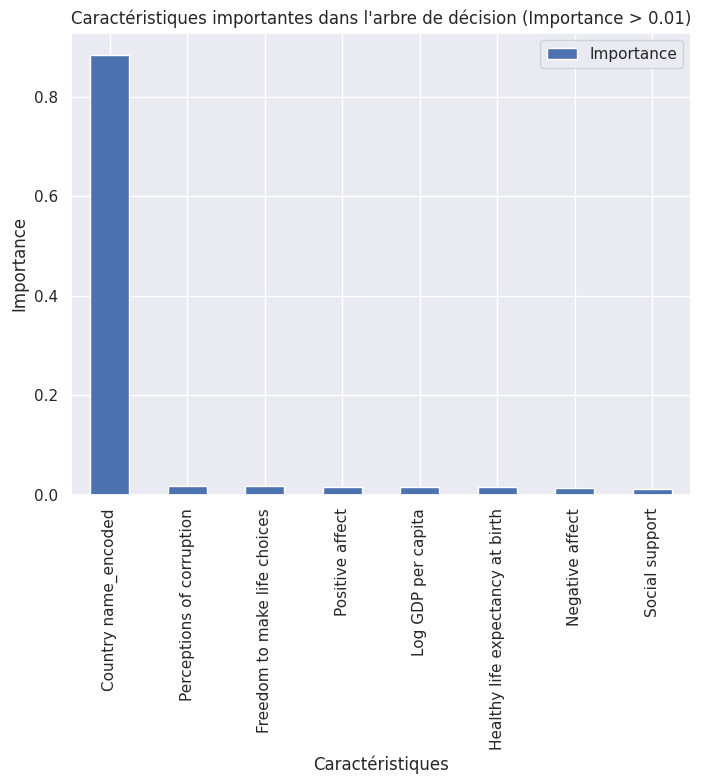

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
feature_importance = tree_regressor_V3.feature_importances_
feat_importances = pd.DataFrame({'Importance': feature_importance}, index=X_train_encoder_V2.columns, columns=["Importance"])

#Déterminer un seuil d'importance pour retirer toutes les variables catégorielles du graphique
seuil_importance = 0.01

# Filtrez les caractéristiques dont l'importance dépasse le seuil
top_features = feat_importances[feat_importances['Importance'] > seuil_importance]
top_features = top_features.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
top_features.plot(kind='bar', figsize=(8, 6))
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.title('Caractéristiques importantes dans l\'arbre de décision (Importance > {})'.format(seuil_importance))
plt.show()

####Test n°2c - Région + année

In [ ]:
#Import
df = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df = df[df["year"] != 2005]
df_1 = df.dropna(axis = 0, how = "any")
df_2e = df_1.sort_values(by = "year", ascending = False)
df_2e = df_2e.merge(df3, on='Country name')

# Division des données en ensembles d'entraînement et de test
y = df_2e ['Life Ladder']
X = df_2e.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Encodage "Pays"
variable_cat2 = ["Regional indicator"]

# Créer un DataFrame temporaire avec X_train et y_train
temp_df = pd.concat([X_train, y_train], axis=1)

# Calculer la moyenne de 'Life Ladder' pour chaque modalité dans l'ensemble d'entraînement
median_encoding_map1 = temp_df.groupby(variable_cat2)['Life Ladder'].median().to_dict()

for variable in variable_cat2:
    X_train[variable + '_encoded'] = X_train[variable].map(median_encoding_map1)

for variable in variable_cat2:
    X_test[variable + '_encoded'] = X_test[variable].map(median_encoding_map1)

#Encodage "Année"
def encodage_year(X):
    dico_annee = {a:b for a, b in zip(range(2006, 2099), range(1,94))}
    X["year"] = X["year"].replace(dico_annee)
    return X

X_train = encodage_year(X_train)
X_test = encodage_year(X_test)

X_train_encoder = X_train.drop(["Country name", "Regional indicator"], axis =1)
X_test_encoder = X_test.drop(["Country name", "Regional indicator"], axis =1)

In [ ]:
X_test_encoder

,year,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Regional indicator_encoded
950,9,8.850,0.813,61.40,0.902,-0.015,0.787,0.813,0.334,5.3850
168,11,9.946,0.900,68.80,0.886,-0.072,0.676,0.842,0.283,6.0040
220,11,9.691,0.895,65.20,0.873,-0.080,0.737,0.760,0.278,6.0040
1179,9,7.600,0.869,45.58,0.681,0.034,0.786,0.570,0.334,4.3140
344,9,10.101,0.795,62.28,0.799,0.004,0.805,0.718,0.169,5.1700
...,...,...,...,...,...,...,...,...,...,...
680,7,10.553,0.930,72.24,0.902,0.287,0.289,0.866,0.207,7.2685
1416,8,9.305,0.809,66.40,0.834,0.268,0.842,0.860,0.208,4.4990
621,4,7.865,0.818,57.70,0.937,0.152,0.965,0.796,0.188,5.3850
163,2,10.437,0.900,67.44,0.799,-0.063,0.928,0.736,0.277,5.4670


In [ ]:
# Entraînement du modèle
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
tree_regressor_V4= DecisionTreeRegressor(random_state=42)
tree_regressor_V4.fit(X_train_encoder, y_train)

# Performance entre le train et le test
print("score train : " , tree_regressor_V4.score(X_train_encoder, y_train))
print("score test : ", tree_regressor_V4.score(X_test_encoder,y_test))

score train :  1.0
score test :  0.7723476478336612


In [ ]:
# Prédictions des valeurs sur l'ensemble de test
y_pred = tree_regressor_V4.predict(X_test_encoder)

#calcul des différents métriques
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE :", mean_squared_error(y_test, y_pred, squared = False))

MAE : 0.37676876876876875
RMSE : 0.5232089483214173


####Test n°2d - Région sans année

In [ ]:
#Import
df = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df = df[df["year"] != 2005]
df_1 = df.dropna(axis = 0, how = "any")
df_2f = df_1.sort_values(by = "year", ascending = False)
df_2f = df_2f.drop("year", axis = 1)
df_2f = df_2f.merge(df3, on='Country name')

# Division des données en ensembles d'entraînement et de test
y = df_2f ['Life Ladder']
X = df_2f.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Encodage "Pays"
variable_cat2 = ["Regional indicator"]

# Créer un DataFrame temporaire avec X_train et y_train
temp_df = pd.concat([X_train, y_train], axis=1)

# Calculer la moyenne de 'Life Ladder' pour chaque modalité dans l'ensemble d'entraînement
median_encoding_map1 = temp_df.groupby(variable_cat2)['Life Ladder'].median().to_dict()

for variable in variable_cat2:
    X_train[variable + '_encoded'] = X_train[variable].map(median_encoding_map1)

for variable in variable_cat2:
    X_test[variable + '_encoded'] = X_test[variable].map(median_encoding_map1)

X_train_encoder_V4 = X_train.drop(["Country name", "Regional indicator"], axis =1)
X_test_encoder_V4 = X_test.drop(["Country name", "Regional indicator"], axis =1)

In [ ]:
# Entraînement du modèle
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
tree_regressor_V5= DecisionTreeRegressor(random_state=42)
tree_regressor_V5.fit(X_train_encoder_V4, y_train)

# Performance entre le train et le test
print("score train : " , tree_regressor_V5.score(X_train_encoder_V4, y_train))
print("score test : ", tree_regressor_V5.score(X_test_encoder_V4,y_test))

score train :  1.0
score test :  0.7861851361627062


In [ ]:
# Prédictions des valeurs sur l'ensemble de test
y_pred = tree_regressor_V5.predict(X_test_encoder_V4)

#calcul des différents métriques
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE :", mean_squared_error(y_test, y_pred, squared = False))

MAE : 0.37443843843843844
RMSE : 0.5070584663411984


###Encodage des variables numériques

In [ ]:
"""
La normalisation et la standardisation sont 2 techniques de mise à l'échelle des données numériques, très répandues dans le domaine des
sciences des données. Leur utilisation diffère cependant en fonction des situations:
- le MinMax est très utile lorsque les échelles des variables sont très hétérogènes. Il vise à mettre les valeurs dans un intervalle de [0-1]
  en calculant l'écart entre la plus petite valeur (0) et la plus grande (1). De part sa méthode, il est peu efficace lorsqu'il y a des valeurs extrêmes
- le standardScaler est plus adapté lorsque les distributions sont en forme de cloche. En centrant les valeurs autour de 0, il garantit que les variances sont les mêmes sur l'ensemble des variables.
  et est peu sensibles aux valeurs extrêmes.

Au vu de la distribution de nos valeurs qui sont quasi toutes en forme de cloche et la présence d'outliers, le standardScaler semble plus adapté.
Mais par précaution, nous testerons les deux techniques et compareront les résultats entre eux.

"""

"\nLa normalisation et la standardisation sont 2 techniques de mise à l'échelle des données numériques, très répandues dans le domaine des\nsciences des données. Leur utilisation diffère cependant en fonction des situations:\n- le MinMax est très utile lorsque les échelles des variables sont très hétérogènes. Il vise à mettre les valeurs dans un intervalle de [0-1]\n  en calculant l'écart entre la plus petite valeur (0) et la plus grande (1). De part sa méthode, il est peu efficace lorsqu'il y a des valeurs extrêmes\n- le standardScaler est plus adapté lorsque les distributions sont en forme de cloche. En centrant les valeurs autour de 0, il garantit que les variances sont les mêmes sur l'ensemble des variables.\n  et est peu sensibles aux valeurs extrêmes.\n\nAu vu de la distribution de nos valeurs qui sont quasi toutes en forme de cloche et la présence d'outliers, le standardScaler semble plus adapté.\nMais par précaution, nous testerons les deux techniques et compareront les résulta

#####Test n°3a - standardscaler


In [ ]:
#Import
df = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df = df[df["year"] != 2005]
df_1 = df.dropna(axis = 0, how = "any")
df_3 = df_1.sort_values(by = "year", ascending = False)
df_3 = df_3.drop("year", axis = 1)
df_3.head()

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
1948,Zimbabwe,3.160,7.829,0.717,56.8,0.643,-0.009,0.789,0.703,0.346
967,Latvia,6.229,10.300,0.928,67.4,0.820,-0.078,0.809,0.714,0.202
1015,Lithuania,6.391,10.504,0.953,68.5,0.824,-0.122,0.829,0.660,0.202
1558,Slovenia,6.462,10.478,0.953,71.7,0.958,-0.081,0.797,0.610,0.314
1454,Russia,5.495,10.162,0.887,65.1,0.714,-0.071,0.823,0.645,0.190


In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_3 ['Life Ladder']
X = df_3.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Encodage "Pays"
variable_cat1 = ["Country name"]

# Créer un DataFrame temporaire avec X_train et y_train
temp_df = pd.concat([X_train, y_train], axis=1)

# Calculer la moyenne de 'Life Ladder' pour chaque modalité dans l'ensemble d'entraînement
mean_encoding_map1 = temp_df.groupby(variable_cat1)['Life Ladder'].mean().to_dict()

for variable in variable_cat1:
    X_train[variable + '_encoded'] = X_train[variable].map(mean_encoding_map1)

for variable in variable_cat1:
    X_test[variable + '_encoded'] = X_test[variable].map(mean_encoding_map1)

X_train_encoder_V6 = X_train.drop(["Country name"], axis =1)
X_test_encoder_V6 = X_test.drop(["Country name"], axis =1)

In [ ]:
#Variables à standardiser
standard_col = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices',
                'Perceptions of corruption', 'Positive affect','Negative affect', 'Country name_encoded']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combiner les prétraitements pour toutes les colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, standard_col)
    ])

In [ ]:
from sklearn.pipeline import make_pipeline

tree = make_pipeline(DecisionTreeRegressor(random_state=42))
linear = make_pipeline(preprocessor, LinearRegression())
knn = make_pipeline(preprocessor, KNeighborsRegressor())
svr = make_pipeline(preprocessor, SVR())

In [ ]:
from sklearn.model_selection import learning_curve
# Liste des modèles à entrainer
models = [
    ('Arbre de décision', tree),
    ('Regression linéaire', linear),
    ('KNN', knn),
    ('SVR', svr),
]
from sklearn.base import clone

# Pipeline complète pour chaque modèle
for model_name, model in models:

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train_encoder_V6, y_train)

    #Performance du modèles
    score_train = model.score(X_train_encoder_V6, y_train)
    score_test = model.score(X_test_encoder_V6,y_test)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test_encoder_V6)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test_encoder_V6)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

Model: Arbre de décision
Performances sur le jeu train: 1.0
Performances sur le jeu test: 0.8521706910502241
MAE: 0.3108567251461989
RMSE: 0.4290816829500822
--------------------------
Model: Regression linéaire
Performances sur le jeu train: 0.8938870449663183
Performances sur le jeu test: 0.8716776798416679
MAE: 0.2958179754452788
RMSE: 0.3997705555111892
--------------------------
Model: KNN
Performances sur le jeu train: 0.9273916326531546
Performances sur le jeu test: 0.8926102836554316
MAE: 0.26454093567251463
RMSE: 0.3657135483068745
--------------------------
Model: SVR
Performances sur le jeu train: 0.9207500688101762
Performances sur le jeu test: 0.8966499846269149
MAE: 0.26691267760224036
RMSE: 0.35876905342337484
--------------------------


#####Test n°3b - minmax

In [ ]:
#Import
df = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df = df[df["year"] != 2005]
df_1 = df.dropna(axis = 0, how = "any")
df_3b = df_1.sort_values(by = "year", ascending = False)
df_3b = df_3b.drop("year", axis = 1)
df_3b.head()

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
1948,Zimbabwe,3.160,7.829,0.717,56.8,0.643,-0.009,0.789,0.703,0.346
967,Latvia,6.229,10.300,0.928,67.4,0.820,-0.078,0.809,0.714,0.202
1015,Lithuania,6.391,10.504,0.953,68.5,0.824,-0.122,0.829,0.660,0.202
1558,Slovenia,6.462,10.478,0.953,71.7,0.958,-0.081,0.797,0.610,0.314
1454,Russia,5.495,10.162,0.887,65.1,0.714,-0.071,0.823,0.645,0.190


In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_3b ['Life Ladder']
X = df_3b.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Encodage "Pays"
variable_cat1 = ["Country name"]

# Créer un DataFrame temporaire avec X_train et y_train
temp_df = pd.concat([X_train, y_train], axis=1)

# Calculer la moyenne de 'Life Ladder' pour chaque modalité dans l'ensemble d'entraînement
mean_encoding_map1 = temp_df.groupby(variable_cat1)['Life Ladder'].mean().to_dict()

for variable in variable_cat1:
    X_train[variable + '_encoded'] = X_train[variable].map(mean_encoding_map1)

for variable in variable_cat1:
    X_test[variable + '_encoded'] = X_test[variable].map(mean_encoding_map1)

X_train_encoder_V7 = X_train.drop(["Country name"], axis =1)
X_test_encoder_V7 = X_test.drop(["Country name"], axis =1)

In [ ]:
#Variables à standardiser
standard_col = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices',
                'Perceptions of corruption', 'Positive affect','Negative affect', 'Country name_encoded']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Combiner les prétraitements pour toutes les colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, standard_col)
    ])

In [ ]:
from sklearn.pipeline import make_pipeline

tree = make_pipeline(DecisionTreeRegressor(random_state=42))
linear = make_pipeline(preprocessor, LinearRegression())
knn = make_pipeline(preprocessor, KNeighborsRegressor())
svr = make_pipeline(preprocessor, SVR())

In [ ]:
from sklearn.model_selection import learning_curve
# Liste des modèles à entrainer
models = [
    ('Arbre de décision', tree),
    ('Regression linéaire', linear),
    ('KNN', knn),
    ('SVR', svr),
]
from sklearn.base import clone

# Pipeline complète pour chaque modèle
for model_name, model in models:

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train_encoder_V7, y_train)

    #Performance du modèles
    score_train = model.score(X_train_encoder_V7, y_train)
    score_test = model.score(X_test_encoder_V7,y_test)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test_encoder_V7)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test_encoder_V7)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

Model: Arbre de décision
Performances sur le jeu train: 1.0
Performances sur le jeu test: 0.8521706910502241
MAE: 0.3108567251461989
RMSE: 0.4290816829500822
--------------------------
Model: Regression linéaire
Performances sur le jeu train: 0.8938870449663183
Performances sur le jeu test: 0.871677679841668
MAE: 0.29581797544527866
RMSE: 0.39977055551118906
--------------------------
Model: KNN
Performances sur le jeu train: 0.929884169639099
Performances sur le jeu test: 0.9038035522319003
MAE: 0.252606432748538
RMSE: 0.34612998183844945
--------------------------
Model: SVR
Performances sur le jeu train: 0.9118347678181955
Performances sur le jeu test: 0.8899694143488222
MAE: 0.2765704265070422
RMSE: 0.37018295191733397
--------------------------


#####Test n°3c - logarithme

In [ ]:
#Import
df = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df = df[df["year"] != 2005]
df_1 = df.dropna(axis = 0, how = "any")
df_3c = df_1.sort_values(by = "year", ascending = False)
df_3c = df_3c.drop("year", axis = 1)

# Division des données en ensembles d'entraînement et de test
y = df_3c ['Life Ladder']
X = df_3c.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Encodage "Pays"
variable_cat1 = ["Country name"]

# Créer un DataFrame temporaire avec X_train et y_train
temp_df = pd.concat([X_train, y_train], axis=1)

# Calculer la moyenne de 'Life Ladder' pour chaque modalité dans l'ensemble d'entraînement
mean_encoding_map1 = temp_df.groupby(variable_cat1)['Life Ladder'].mean().to_dict()

for variable in variable_cat1:
    X_train[variable + '_encoded'] = X_train[variable].map(mean_encoding_map1)

for variable in variable_cat1:
    X_test[variable + '_encoded'] = X_test[variable].map(mean_encoding_map1)

X_train_encoder_log = X_train.drop(["Country name"], axis =1)
X_test_encoder_log = X_test.drop(["Country name"], axis =1)

#Logarithme sur la variable "Healthy"
X_train_encoder_log["Healthy life expectancy at birth"] = np.log10(X_train_encoder_log["Healthy life expectancy at birth"])
X_test_encoder_log["Healthy life expectancy at birth"] = np.log10(X_test_encoder_log["Healthy life expectancy at birth"])

#Variables à standardiser
standard_col = ['Log GDP per capita', 'Social support', 'Freedom to make life choices','Healthy life expectancy at birth',
                'Perceptions of corruption', 'Positive affect','Negative affect', 'Country name_encoded']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combiner les prétraitements pour toutes les colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, standard_col)
    ])

In [ ]:
from sklearn.pipeline import make_pipeline

tree = make_pipeline(DecisionTreeRegressor(random_state=42))
linear = make_pipeline(preprocessor, LinearRegression())
knn = make_pipeline(preprocessor, KNeighborsRegressor())
svr = make_pipeline(preprocessor, SVR())

from sklearn.model_selection import learning_curve
# Liste des modèles à entrainer
models = [
    ('Arbre de décision', tree),
    ('Regression linéaire', linear),
    ('KNN', knn),
    ('SVR', svr),
]
from sklearn.base import clone

# Pipeline complète pour chaque modèle
for model_name, model in models:

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train_encoder_log, y_train)

    #Performance du modèles
    score_train = model.score(X_train_encoder_log, y_train)
    score_test = model.score(X_test_encoder_log,y_test)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test_encoder_log)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test_encoder_log)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

Model: Arbre de décision
Performances sur le jeu train: 1.0
Performances sur le jeu test: 0.8521956736098819
MAE: 0.3106725146198831
RMSE: 0.4290454248773516
--------------------------
Model: Regression linéaire
Performances sur le jeu train: 0.8938800684609418
Performances sur le jeu test: 0.8717164986764367
MAE: 0.2959322905732928
RMSE: 0.3997100835647081
--------------------------
Model: KNN
Performances sur le jeu train: 0.9283164334409593
Performances sur le jeu test: 0.8913080791081871
MAE: 0.2673947368421053
RMSE: 0.3679241828522357
--------------------------
Model: SVR
Performances sur le jeu train: 0.9209050558592103
Performances sur le jeu test: 0.8965575222930053
MAE: 0.26723223755706693
RMSE: 0.35892950433245263
--------------------------


###Gestion des Nan

In [ ]:
df_nan = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
nan = df_nan[df_nan.isna().any(axis =1) == True]
occurence_nan = nan["Country name"].value_counts()


In [ ]:
pays = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
occurence_pays = pays["Country name"].value_counts()
occurence_pays

Zimbabwe        15
South Africa    15
Tanzania        15
Denmark         15
Tajikistan      15
                ..
Maldives         1
Suriname         1
Cuba             1
Oman             1
Guyana           1
Name: Country name, Length: 166, dtype: int64

In [ ]:
comparaison = occurence_pays - occurence_nan
comparaison

Afghanistan     NaN
Albania         NaN
Algeria         5.0
Angola          NaN
Argentina       NaN
               ... 
Venezuela      11.0
Vietnam        10.0
Yemen           7.0
Zambia          NaN
Zimbabwe        NaN
Name: Country name, Length: 166, dtype: float64

In [ ]:
pays[pays["Country name"] == "Algeria"]

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
25,Algeria,2010,5.464,9.287,NaN,64.50,0.593,-0.205,0.618,NaN,NaN
26,Algeria,2011,5.317,9.297,0.810,64.66,0.530,-0.181,0.638,0.550,0.255
27,Algeria,2012,5.605,9.311,0.839,64.82,0.587,-0.172,0.690,0.604,0.230
28,Algeria,2014,6.355,9.335,0.818,65.14,NaN,NaN,NaN,0.626,0.177
29,Algeria,2016,5.341,9.362,0.749,65.50,NaN,NaN,NaN,0.661,0.377
30,Algeria,2017,5.249,9.354,0.807,65.70,0.437,-0.167,0.700,0.642,0.289
31,Algeria,2018,5.043,9.348,0.799,65.90,0.583,-0.146,0.759,0.591,0.293
32,Algeria,2019,4.745,9.337,0.803,66.10,0.385,0.005,0.741,0.585,0.215


In [ ]:
comparaison_sans_nan = comparaison.dropna()
comparaison_sans_nan[comparaison_sans_nan < 0]

Series([], Name: Country name, dtype: float64)

####Test n°4a - hors KNN (avec création d'une fonction)

In [ ]:
df_4a = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_4a = df_4a.sort_values(by = "year", ascending = False)
df_4a = df_4a.drop("year", axis = 1)
df_4a = df_4a.merge(df3, on='Country name')
df_4a.head()

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Regional indicator
0,Zimbabwe,3.160,7.829,0.717,56.8,0.643,-0.009,0.789,0.703,0.346,Sub-Saharan Africa
1,Zimbabwe,2.694,7.950,0.759,56.2,0.632,-0.064,0.831,0.716,0.235,Sub-Saharan Africa
2,Zimbabwe,3.616,8.049,0.775,55.6,0.763,-0.068,0.844,0.710,0.212,Sub-Saharan Africa
3,Zimbabwe,3.638,8.016,0.754,55.0,0.753,-0.098,0.751,0.806,0.224,Sub-Saharan Africa
4,Zimbabwe,3.735,7.984,0.768,54.4,0.733,-0.095,0.724,0.738,0.209,Sub-Saharan Africa


In [ ]:
df_4a.isna().sum()

Country name                          0
Life Ladder                           0
Log GDP per capita                   24
Social support                        9
Healthy life expectancy at birth     51
Freedom to make life choices         30
Generosity                           76
Perceptions of corruption           104
Positive affect                      18
Negative affect                      13
Regional indicator                    0
dtype: int64

In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_4a ['Life Ladder']
X = df_4a.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
col_numeric = ["Log GDP per capita", "Social support",'Healthy life expectancy at birth',
               "Freedom to make life choices", "Generosity", "Perceptions of corruption",
               "Positive affect", "Negative affect"]

def gestion_nan1(X):
  for colonne in col_numeric:
    if 'Regional indicator' in X.columns:
      X[colonne] = X[colonne].fillna(X.groupby("Regional indicator")[colonne].transform('median'))

  X_new = X.drop(["Regional indicator"], axis=1, inplace=True)

  return X_new

gestion_nan1(X_train)
gestion_nan1(X_test)

In [ ]:
X_train.head()

,Country name,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
710,Thailand,9.699,0.866,66.60,0.885,0.316,0.914,0.910,0.174
931,France,10.669,0.937,72.60,0.841,-0.149,0.608,0.754,0.253
617,Cameroon,8.090,0.760,49.50,0.794,-0.030,0.867,0.681,0.268
1798,Belarus,9.576,0.858,61.40,0.667,-0.225,0.695,0.596,0.235
271,Italy,10.727,0.912,72.26,0.684,0.113,0.922,0.716,0.303


In [ ]:
#Encodage "Pays"
variable_cat1 = ["Country name"]

# Créer un DataFrame temporaire avec X_train et y_train
temp_df = pd.concat([X_train, y_train], axis=1)

# Calculer la moyenne de 'Life Ladder' pour chaque modalité dans l'ensemble d'entraînement
mean_encoding_map1 = temp_df.groupby(variable_cat1)['Life Ladder'].mean().to_dict()

for variable in variable_cat1:
    X_train[variable + '_encoded'] = X_train[variable].map(mean_encoding_map1)

for variable in variable_cat1:
    X_test[variable + '_encoded'] = X_test[variable].map(mean_encoding_map1)

X_train_encoder_V5a = X_train.drop(["Country name"], axis =1)
X_test_encoder_V5a  = X_test.drop(["Country name"], axis =1)

In [ ]:
X_train_encoder_V5a

,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Country name_encoded
710,9.699,0.866,66.60,0.885,0.316,0.914,0.910,0.174,6.087250
931,10.669,0.937,72.60,0.841,-0.149,0.608,0.754,0.253,6.648750
617,8.090,0.760,49.50,0.794,-0.030,0.867,0.681,0.268,4.541727
1798,9.576,0.858,61.40,0.667,-0.225,0.695,0.596,0.235,5.571071
271,10.727,0.912,72.26,0.684,0.113,0.922,0.716,0.303,6.274273
...,...,...,...,...,...,...,...,...,...
1130,8.984,0.856,61.12,0.551,-0.099,0.925,0.562,0.306,5.616769
1294,7.632,0.638,50.88,0.684,0.006,0.705,0.629,0.351,3.856143
860,9.579,0.726,66.20,0.463,-0.170,0.965,0.532,0.415,5.363000
1459,9.561,0.908,61.80,0.720,0.066,0.820,0.521,0.350,5.842333


In [ ]:
#Variables à standardiser
standard_col = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices',
                'Perceptions of corruption', 'Positive affect','Negative affect', 'Country name_encoded']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combiner les prétraitements pour toutes les colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, standard_col)
    ])

In [ ]:
from sklearn.pipeline import make_pipeline

tree = make_pipeline(DecisionTreeRegressor(random_state=42))
linear = make_pipeline(preprocessor, LinearRegression())
svr = make_pipeline(preprocessor, SVR())

In [ ]:
from sklearn.model_selection import learning_curve
# Liste des modèles à entrainer
models = [
    ('Arbre de décision', tree),
    ('Regression linéaire', linear),
    ('SVR', svr),
]
from sklearn.base import clone

# Pipeline complète pour chaque modèle
for model_name, model in models:

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train_encoder_V5a, y_train)

    #Performance du modèles
    score_train = model.score(X_train_encoder_V5a, y_train)
    score_test = model.score(X_test_encoder_V5a,y_test)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test_encoder_V5a)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

Model: Arbre de décision
Performances sur le jeu train: 1.0
Performances sur le jeu test: 0.8038638425615031
MAE: 0.35530687830687835
RMSE: 0.46612470797657074
--------------------------
Model: Regression linéaire
Performances sur le jeu train: 0.8906991432827779
Performances sur le jeu test: 0.8560769975369145
MAE: 0.3018190629304648
RMSE: 0.39928996740777806
--------------------------
Model: SVR
Performances sur le jeu train: 0.9200925687403664
Performances sur le jeu test: 0.8794402583006332
MAE: 0.27197116206919314
RMSE: 0.3654470389735292
--------------------------


####Test n°4b - hors KNN (avec imputer)

In [ ]:
#Import
df_4b = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_4b = df_4b[df_4b["year"] != 2005]
df_4b = df_4b.sort_values(by = "year", ascending = False)
df_4b = df_4b.drop("year", axis = 1)
df_4b.head()

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
1948,Zimbabwe,3.160,7.829,0.717,56.8,0.643,-0.009,0.789,0.703,0.346
578,France,6.714,10.643,0.947,74.2,0.823,-0.169,0.565,0.732,0.231
422,Croatia,6.508,10.166,0.923,71.4,0.837,-0.063,0.961,0.743,0.286
436,Cyprus,6.260,NaN,0.806,74.1,0.763,NaN,0.816,0.759,0.284
1238,New Zealand,7.257,10.600,0.952,73.6,0.918,0.125,0.283,0.849,0.209


In [ ]:
df_4b.isna().sum()

Country name                          0
Life Ladder                           0
Log GDP per capita                   36
Social support                       13
Healthy life expectancy at birth     55
Freedom to make life choices         30
Generosity                           63
Perceptions of corruption           108
Positive affect                      21
Negative affect                      15
dtype: int64

In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_4b ['Life Ladder']
X = df_4b.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Encodage "Pays"
variable_cat1 = ["Country name"]

# Créer un DataFrame temporaire avec X_train et y_train
temp_df = pd.concat([X_train, y_train], axis=1)

# Calculer la moyenne de 'Life Ladder' pour chaque modalité dans l'ensemble d'entraînement
mean_encoding_map1 = temp_df.groupby(variable_cat1)['Life Ladder'].mean().to_dict()

for variable in variable_cat1:
    X_train[variable + '_encoded'] = X_train[variable].map(mean_encoding_map1)

for variable in variable_cat1:
    X_test[variable + '_encoded'] = X_test[variable].map(mean_encoding_map1)

X_train_encoder_V9 = X_train.drop(["Country name"], axis =1)
X_test_encoder_V9 = X_test.drop(["Country name"], axis =1)

In [ ]:
X_train_encoder_V9.head()

,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Country name_encoded
30,9.354,0.807,65.70,0.437,-0.167,0.700,0.642,0.289,5.389875
377,8.033,0.632,57.50,0.538,0.077,0.762,0.736,0.336,4.087500
488,9.304,0.818,66.96,0.788,-0.155,0.702,0.862,0.271,5.774000
1117,9.867,0.761,67.40,0.719,-0.152,0.708,0.745,0.237,6.700500
651,8.891,0.866,61.08,0.628,0.136,0.810,0.819,0.224,6.211909


In [ ]:
#Variables à standardiser
standard_col = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices',
                'Perceptions of corruption', 'Positive affect','Negative affect', 'Country name_encoded']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Combiner les prétraitements pour toutes les colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, standard_col)
    ])

In [ ]:
from sklearn.pipeline import make_pipeline

tree = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))
linear = make_pipeline(preprocessor, LinearRegression())
svr = make_pipeline(preprocessor, SVR())

In [ ]:
from sklearn.model_selection import learning_curve
# Liste des modèles à entrainer
models = [
    ('Arbre de décision', tree),
    ('Regression linéaire', linear),
    ('SVR', svr),
]
from sklearn.base import clone

# Pipeline complète pour chaque modèle
for model_name, model in models:

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train_encoder_V9, y_train)

    #Performance du modèles
    score_train = model.score(X_train_encoder_V9, y_train)
    score_test = model.score(X_test_encoder_V9,y_test)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test_encoder_V9)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

Model: Arbre de décision
Performances sur le jeu train: 1.0
Performances sur le jeu test: 0.8331965352966404
MAE: 0.33923896103896106
RMSE: 0.44635223118711337
--------------------------
Model: Regression linéaire
Performances sur le jeu train: 0.892079325848584
Performances sur le jeu test: 0.8515583442666927
MAE: 0.3113960688540979
RMSE: 0.42106880847009975
--------------------------
Model: SVR
Performances sur le jeu train: 0.9099158943813273
Performances sur le jeu test: 0.8687359401573934
MAE: 0.2990245245625751
RMSE: 0.39595706151916854
--------------------------


####Test n°4c - KNN - créa fonction

In [ ]:
#Import
df_4c = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_4c = df_4c[df_4c["year"] != 2005]
df_4c = df_4c.merge(df3, on='Country name')
df_4c = df_4c.sort_values(by = "year", ascending = False)
df_4c = df_4c.drop("year", axis = 1)

In [ ]:
df_4c.isna().sum()

Country name                          0
Life Ladder                           0
Log GDP per capita                   24
Social support                        9
Healthy life expectancy at birth     51
Freedom to make life choices         28
Generosity                           50
Perceptions of corruption           102
Positive affect                      17
Negative affect                      12
Regional indicator                    0
dtype: int64

In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_4c ['Life Ladder']
X = df_4c.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

col_numeric = ["Log GDP per capita", "Social support",'Healthy life expectancy at birth',
               "Freedom to make life choices", "Generosity", "Perceptions of corruption",
               "Positive affect", "Negative affect"]

def gestion_nan1(X):
  for colonne in col_numeric:
    if 'Regional indicator' in X.columns:
      X[colonne] = X[colonne].fillna(X.groupby("Regional indicator")[colonne].transform('median'))

  X_new = X.drop(["Regional indicator"], axis=1, inplace=True)

  return X_new

gestion_nan1(X_train)
gestion_nan1(X_test)

#Encodage "Pays"
variable_cat1 = ["Country name"]

# Créer un DataFrame temporaire avec X_train et y_train
temp_df = pd.concat([X_train, y_train], axis=1)

# Calculer la moyenne de 'Life Ladder' pour chaque modalité dans l'ensemble d'entraînement
mean_encoding_map1 = temp_df.groupby(variable_cat1)['Life Ladder'].mean().to_dict()

for variable in variable_cat1:
    X_train[variable + '_encoded'] = X_train[variable].map(mean_encoding_map1)

for variable in variable_cat1:
    X_test[variable + '_encoded'] = X_test[variable].map(mean_encoding_map1)

X_train_encoder_V5c = X_train.drop(["Country name"], axis =1)
X_test_encoder_V5c = X_test.drop(["Country name"], axis =1)

In [ ]:
from sklearn.impute import KNNImputer

#Variables à standardiser
standard_col = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices',
                'Perceptions of corruption', 'Positive affect','Negative affect', 'Country name_encoded']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Combiner les prétraitements pour toutes les colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, standard_col)
    ])

In [ ]:
from sklearn.pipeline import make_pipeline

knn = make_pipeline(preprocessor, KNeighborsRegressor())

from sklearn.model_selection import learning_curve
# Liste des modèles à entrainer
models = [
    ('KNN', knn)
]
from sklearn.base import clone

# Pipeline complète pour chaque modèle
for model_name, model in models:

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train_encoder_V5c, y_train)

    #Performance du modèles
    score_train = model.score(X_train_encoder_V5c, y_train)
    score_test = model.score(X_test_encoder_V5c,y_test)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test_encoder_V5c)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")


Model: KNN
Performances sur le jeu train: 0.9284773947417679
Performances sur le jeu test: 0.8991987302672947
MAE: 0.2609860215053763
RMSE: 0.35266559414028836
--------------------------


####Test n°4d - KNN - imputer

In [ ]:
#Import
df_4d = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_4d = df_4d[df_4d["year"] != 2005]
df_4d = df_4d.sort_values(by = "year", ascending = False)
df_4d = df_4d.drop("year", axis = 1)
df_4d.head()

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
1948,Zimbabwe,3.160,7.829,0.717,56.8,0.643,-0.009,0.789,0.703,0.346
578,France,6.714,10.643,0.947,74.2,0.823,-0.169,0.565,0.732,0.231
422,Croatia,6.508,10.166,0.923,71.4,0.837,-0.063,0.961,0.743,0.286
436,Cyprus,6.260,NaN,0.806,74.1,0.763,NaN,0.816,0.759,0.284
1238,New Zealand,7.257,10.600,0.952,73.6,0.918,0.125,0.283,0.849,0.209


In [ ]:
df_4d.isna().sum()

Country name                          0
Life Ladder                           0
Log GDP per capita                   36
Social support                       13
Healthy life expectancy at birth     55
Freedom to make life choices         30
Generosity                           63
Perceptions of corruption           108
Positive affect                      21
Negative affect                      15
dtype: int64

In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_4d ['Life Ladder']
X = df_4d.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Encodage "Pays"
variable_cat1 = ["Country name"]

# Créer un DataFrame temporaire avec X_train et y_train
temp_df = pd.concat([X_train, y_train], axis=1)

# Calculer la moyenne de 'Life Ladder' pour chaque modalité dans l'ensemble d'entraînement
mean_encoding_map1 = temp_df.groupby(variable_cat1)['Life Ladder'].mean().to_dict()

for variable in variable_cat1:
    X_train[variable + '_encoded'] = X_train[variable].map(mean_encoding_map1)

for variable in variable_cat1:
    X_test[variable + '_encoded'] = X_test[variable].map(mean_encoding_map1)

X_train_encoder_V5d = X_train.drop(["Country name"], axis =1)
X_test_encoder_V5d = X_test.drop(["Country name"], axis =1)

In [ ]:
#Variables à standardiser
standard_col = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices',
                'Perceptions of corruption', 'Positive affect','Negative affect', 'Country name_encoded']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Combiner les prétraitements pour toutes les colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, standard_col)
    ])

In [ ]:
from sklearn.pipeline import make_pipeline

knn = make_pipeline(preprocessor, KNeighborsRegressor())

# Liste des modèles à entrainer
models = [
    ('KNN', knn)
]
from sklearn.base import clone

# Pipeline complète pour chaque modèle
for model_name, model in models:

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train_encoder_V5d, y_train)

    #Performance du modèles
    score_train = model.score(X_train_encoder_V5d, y_train)
    score_test = model.score(X_test_encoder_V5d,y_test)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test_encoder_V5d)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

Model: KNN
Performances sur le jeu train: 0.931914634401461
Performances sur le jeu test: 0.8725589485014098
MAE: 0.29043480519480525
RMSE: 0.3901484173138058
--------------------------


###Feature Engineering

####Ordre d'importance des variables

In [ ]:
#Import
df = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df = df[df["year"] != 2005]
df_features = df.sort_values(by = "year", ascending = False)
df_features = df_features.drop("year", axis = 1)
df_features = df_features.merge(df3, on='Country name')
df_features.head()

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Regional indicator
0,Zimbabwe,3.160,7.829,0.717,56.8,0.643,-0.009,0.789,0.703,0.346,Sub-Saharan Africa
1,Zimbabwe,2.694,7.950,0.759,56.2,0.632,-0.064,0.831,0.716,0.235,Sub-Saharan Africa
2,Zimbabwe,3.616,8.049,0.775,55.6,0.763,-0.068,0.844,0.710,0.212,Sub-Saharan Africa
3,Zimbabwe,3.638,8.016,0.754,55.0,0.753,-0.098,0.751,0.806,0.224,Sub-Saharan Africa
4,Zimbabwe,3.735,7.984,0.768,54.4,0.733,-0.095,0.724,0.738,0.209,Sub-Saharan Africa


In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_features ['Life Ladder']
X = df_features.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Encodage "Pays"
variable_cat1 = ["Country name"]

# Créer un DataFrame temporaire avec X_train et y_train
temp_df = pd.concat([X_train, y_train], axis=1)

# Calculer la moyenne de 'Life Ladder' pour chaque modalité dans l'ensemble d'entraînement
mean_encoding_map1 = temp_df.groupby(variable_cat1)['Life Ladder'].mean().to_dict()

for variable in variable_cat1:
    X_train[variable + '_encoded'] = X_train[variable].map(mean_encoding_map1)

for variable in variable_cat1:
    X_test[variable + '_encoded'] = X_test[variable].map(mean_encoding_map1)

X_train_encoder_features = X_train.drop(["Country name"], axis =1)
X_test_encoder_features = X_test.drop(["Country name"], axis =1)

In [ ]:
X_train_encoder_features

,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Regional indicator,Country name_encoded
244,9.246,0.840,62.90,0.595,-0.090,0.943,0.590,0.281,Commonwealth of Independent States,5.553545
1189,8.387,0.553,57.70,0.838,-0.038,0.908,0.648,0.232,South Asia,4.433643
1073,8.192,0.825,57.18,0.708,0.212,0.861,0.765,0.161,Sub-Saharan Africa,4.392643
1080,8.039,0.909,50.22,0.616,-0.020,0.860,0.705,0.198,Sub-Saharan Africa,4.392643
1229,11.199,0.958,72.10,0.875,0.174,0.399,0.809,0.211,Western Europe,7.039400
...,...,...,...,...,...,...,...,...,...,...
1130,9.932,0.902,68.56,0.904,-0.073,0.533,0.869,0.251,Latin America and Caribbean,6.301846
1294,7.457,0.734,45.10,0.505,0.025,0.858,0.545,0.287,Sub-Saharan Africa,4.000000
860,9.186,0.910,66.08,0.671,-0.091,0.901,0.825,0.357,Latin America and Caribbean,5.793615
1459,9.639,0.780,58.70,0.699,-0.204,0.817,0.640,0.432,Sub-Saharan Africa,4.405667


In [ ]:
col_numeric = ["Log GDP per capita", "Social support",'Healthy life expectancy at birth',
               "Freedom to make life choices", "Generosity", "Perceptions of corruption",
               "Positive affect", "Negative affect"]

def gestion_nan1(X):
  for colonne in col_numeric:
    if 'Country name' in X.columns:
      X[colonne] = X[colonne].fillna(X.groupby("Country name")[colonne].transform('mean'))
    if 'Regional indicator' in X.columns:
      X[colonne] = X[colonne].fillna(X.groupby("Regional indicator")[colonne].transform('median'))

  return X

gestion_nan1(X_train_encoder_features)
gestion_nan1(X_test_encoder_features)

,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Regional indicator,Country name_encoded
233,9.240,0.737,60.32,0.452,-0.138,0.880,0.527,0.398,Middle East and North Africa,4.460273
450,10.605,0.910,74.40,0.722,-0.075,0.777,0.659,0.357,Western Europe,6.466583
1202,10.939,0.925,68.64,0.792,0.274,0.747,0.814,0.260,North America and ANZ,7.085538
1244,9.449,0.572,65.10,0.780,0.176,0.699,0.645,0.520,Middle East and North Africa,4.844556
411,8.164,0.577,62.38,0.736,-0.098,0.789,0.665,0.231,South Asia,4.746667
...,...,...,...,...,...,...,...,...,...,...
777,7.764,0.790,56.00,0.759,0.149,0.906,0.619,0.192,Sub-Saharan Africa,3.667167
413,8.070,0.582,61.54,0.668,-0.034,0.765,0.714,0.183,South Asia,4.746667
271,9.884,0.893,67.70,0.752,-0.153,0.809,0.859,0.220,Latin America and Caribbean,6.666727
184,9.913,0.887,68.90,0.802,0.060,0.845,0.603,0.411,Central and Eastern Europe,5.253000


In [ ]:
X_train_encoder_features = X_train_encoder_features.drop("Regional indicator", axis = 1)
X_test_encoder_features = X_test_encoder_features.drop("Regional indicator", axis = 1)

In [ ]:
col_numeric = ["Log GDP per capita", "Social support",'Healthy life expectancy at birth',
               "Freedom to make life choices", "Generosity", "Perceptions of corruption",
               "Positive affect", "Negative affect", "Country name_encoded"]
scaler = StandardScaler()
X_train_encoder_features[col_numeric] = scaler.fit_transform(X_train_encoder_features[col_numeric])
X_test_encoder_features[col_numeric] = scaler.transform(X_test_encoder_features[col_numeric])

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_features = DecisionTreeRegressor(random_state=42)
tree_features.fit(X_train_encoder_features, y_train)

DecisionTreeRegressor(random_state=42)

<Axes: >

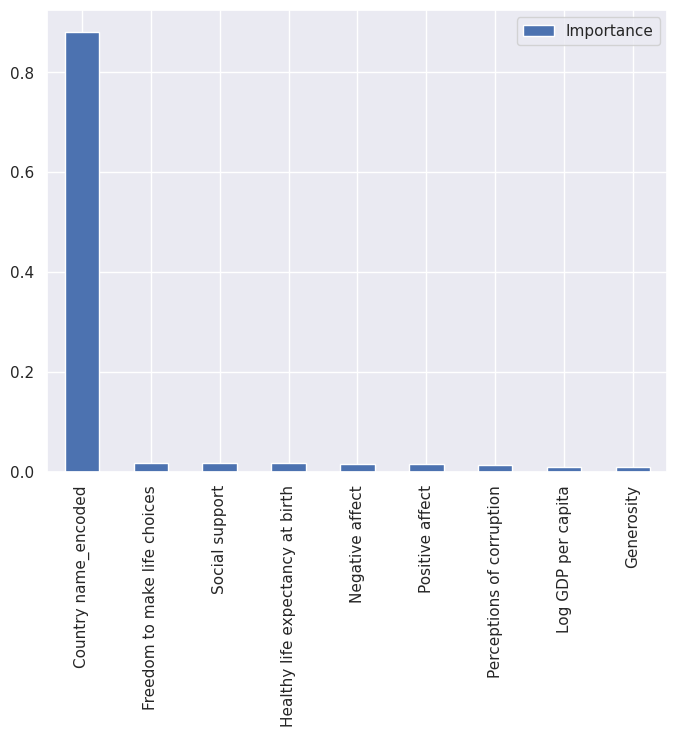

In [ ]:
#Importance des variables sous forme de plot

import matplotlib.pyplot as plt
%matplotlib inline
feat_importances = pd.DataFrame(tree_features.feature_importances_, index=X_train_encoder_features.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

In [ ]:
"""
Objectifs =
- minimiser le poids de la variable "pays",
- améliorer les performances,
- tenter de trouver des groupes de pays aux combinaisons de variables similaires

Proposition : ajouter une caractéristique dérivée pour minimiser l'impact de pays
- ajout de la région
- ajout de cluster à l'aide d'un K-MEANS
"""


'\nObjectifs =\n- minimiser le poids de la variable "pays",\n- améliorer les performances,\n- tenter de trouver des groupes de pays aux combinaisons de variables similaires\n\nProposition : ajouter une caractéristique dérivée pour minimiser l\'impact de pays\n- ajout de la région\n- ajout de cluster à l\'aide d\'un K-MEANS\n'

####Test n°5a - ajout de la région avec un targetencoder

In [ ]:
#Import
df_5a = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_5a = df_5a.merge(df3, on='Country name')
#df_5a = df_5a.dropna(axis = 0, how = "any")
df_5a = df_5a[df_5a["year"] != 2005]
df_5a = df_5a.sort_values(by = "year", ascending = False)
df_5a = df_5a.drop("year", axis = 1)
df_5a

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Regional indicator
1885,Zimbabwe,3.160,7.829,0.717,56.80,0.643,-0.009,0.789,0.703,0.346,Sub-Saharan Africa
1668,Thailand,5.885,9.769,0.867,67.60,0.840,0.273,0.918,0.783,0.326,Southeast Asia
128,Bangladesh,5.280,8.472,0.739,65.30,0.777,-0.009,0.742,0.582,0.332,South Asia
608,Ghana,5.319,8.590,0.643,58.00,0.824,0.200,0.847,0.713,0.253,Sub-Saharan Africa
1379,Poland,6.139,10.371,0.953,70.10,0.767,-0.007,0.787,0.760,0.329,Central and Eastern Europe
...,...,...,...,...,...,...,...,...,...,...,...
169,Bolivia,5.374,8.686,0.834,59.00,0.770,-0.044,0.794,0.739,0.432,Latin America and Caribbean
1169,Nepal,4.567,7.616,0.874,57.20,0.689,NaN,0.897,0.717,0.171,South Asia
891,Kuwait,6.076,11.228,0.919,63.96,0.769,-0.236,0.328,0.846,0.182,Middle East and North Africa
1715,Uganda,3.734,7.370,0.760,46.48,0.747,-0.041,0.807,0.590,0.254,Sub-Saharan Africa


In [ ]:
df_5a.isna().sum()

Country name                          0
Life Ladder                           0
Log GDP per capita                   24
Social support                        9
Healthy life expectancy at birth     51
Freedom to make life choices         28
Generosity                           50
Perceptions of corruption           102
Positive affect                      17
Negative affect                      12
Regional indicator                    0
dtype: int64

In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_5a ['Life Ladder']
X = df_5a.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
col_numeric = ["Log GDP per capita", "Social support",'Healthy life expectancy at birth',
               "Freedom to make life choices", "Generosity", "Perceptions of corruption",
               "Positive affect", "Negative affect"]

def gestion_nan1(X):
  for colonne in col_numeric:
    if 'Regional indicator' in X.columns:
      X[colonne] = X[colonne].fillna(X.groupby("Regional indicator")[colonne].transform('median'))

  return X

gestion_nan1(X_train)
gestion_nan1(X_test)

,Country name,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Regional indicator
155,Belgium,10.853,0.884,72.2,0.776,-0.172,0.672,0.733,0.244,Western Europe
1417,Russia,10.166,0.896,63.9,0.731,-0.145,0.862,0.710,0.195,Commonwealth of Independent States
1138,Morocco,8.799,0.676,64.1,0.757,-0.187,0.845,0.687,0.281,Middle East and North Africa
1315,Panama,10.059,0.876,68.5,0.829,0.009,0.840,0.885,0.180,Latin America and Caribbean
1207,New Zealand,10.633,0.955,73.0,0.942,0.294,0.222,0.817,0.172,North America and ANZ
...,...,...,...,...,...,...,...,...,...,...
1374,Poland,10.235,0.893,68.1,0.793,-0.093,0.810,0.734,0.240,Central and Eastern Europe
1484,Sierra Leone,7.404,0.652,49.2,0.711,0.079,0.848,0.600,0.495,Sub-Saharan Africa
362,Comoros,8.028,0.621,57.2,0.560,0.086,0.794,0.748,0.337,Sub-Saharan Africa
607,Ghana,8.596,0.746,57.6,0.787,0.116,0.857,0.682,0.270,Sub-Saharan Africa


In [ ]:
# Colonnes catégorielles et numériques
categorical_cols = ['Regional indicator', 'Country name']
numeric_cols = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
                'Positive affect', 'Negative affect']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Prétraitement des colonnes catégorielles
categorical_transformer = Pipeline(steps=[
    ('targetencoder', TargetEncoder())
])

# Combiner les prétraitements numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

In [ ]:
from sklearn.pipeline import make_pipeline
tree = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))
linear = make_pipeline(preprocessor, LinearRegression())
knn = make_pipeline(preprocessor, KNeighborsRegressor())
svr = make_pipeline(preprocessor, SVR())

from sklearn.model_selection import learning_curve
# Liste des modèles à entrainer
models = [
    ('Arbre de décision', tree),
    ('Regression linéaire', linear),
    ('KNN', knn),
    ('SVR', svr),
]

# Pipeline complète pour chaque modèle
for model_name, model in models:

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    #Performance du modèles
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test,y_test)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test)


    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

Model: Arbre de décision
Performances sur le jeu train: 1.0
Performances sur le jeu test: 0.8352437421856935
MAE: 0.32894354838709683
RMSE: 0.45086970020077843
--------------------------
Model: Regression linéaire
Performances sur le jeu train: 0.8750448484280553
Performances sur le jeu test: 0.8807209420903708
MAE: 0.30639086547405425
RMSE: 0.38362967246621354
--------------------------
Model: KNN
Performances sur le jeu train: 0.9140051602590603
Performances sur le jeu test: 0.8847632812219537
MAE: 0.2871387096774194
RMSE: 0.37707308381484145
--------------------------
Model: SVR
Performances sur le jeu train: 0.8649915016405245
Performances sur le jeu test: 0.8747372495336881
MAE: 0.3037899270853568
RMSE: 0.3931344140810742
--------------------------


####Test n°5b - ajout de la région avec OneHotEncoder

In [ ]:
#Import
df_5b = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_5b = df_5b.merge(df3, on='Country name')
df_5b = df_5b[df_5b["year"] != 2005]
#df_5b = df_5b.dropna(axis = 0, how = "any")
df_5b = df_5b.sort_values(by = "year", ascending = False)
df_5b = df_5b.drop("year", axis = 1)
df_5b

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Regional indicator
1885,Zimbabwe,3.160,7.829,0.717,56.80,0.643,-0.009,0.789,0.703,0.346,Sub-Saharan Africa
1668,Thailand,5.885,9.769,0.867,67.60,0.840,0.273,0.918,0.783,0.326,Southeast Asia
128,Bangladesh,5.280,8.472,0.739,65.30,0.777,-0.009,0.742,0.582,0.332,South Asia
608,Ghana,5.319,8.590,0.643,58.00,0.824,0.200,0.847,0.713,0.253,Sub-Saharan Africa
1379,Poland,6.139,10.371,0.953,70.10,0.767,-0.007,0.787,0.760,0.329,Central and Eastern Europe
...,...,...,...,...,...,...,...,...,...,...,...
169,Bolivia,5.374,8.686,0.834,59.00,0.770,-0.044,0.794,0.739,0.432,Latin America and Caribbean
1169,Nepal,4.567,7.616,0.874,57.20,0.689,NaN,0.897,0.717,0.171,South Asia
891,Kuwait,6.076,11.228,0.919,63.96,0.769,-0.236,0.328,0.846,0.182,Middle East and North Africa
1715,Uganda,3.734,7.370,0.760,46.48,0.747,-0.041,0.807,0.590,0.254,Sub-Saharan Africa


In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_5b ['Life Ladder']
X = df_5b.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
col_numeric = ["Log GDP per capita", "Social support",'Healthy life expectancy at birth',
               "Freedom to make life choices", "Generosity", "Perceptions of corruption",
               "Positive affect", "Negative affect"]

def gestion_nan1(X):
  for colonne in col_numeric:
    if 'Regional indicator' in X.columns:
      X[colonne] = X[colonne].fillna(X.groupby("Regional indicator")[colonne].transform('median'))

  return X

gestion_nan1(X_train)
gestion_nan1(X_test)

,Country name,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Regional indicator
155,Belgium,10.853,0.884,72.2,0.776,-0.172,0.672,0.733,0.244,Western Europe
1417,Russia,10.166,0.896,63.9,0.731,-0.145,0.862,0.710,0.195,Commonwealth of Independent States
1138,Morocco,8.799,0.676,64.1,0.757,-0.187,0.845,0.687,0.281,Middle East and North Africa
1315,Panama,10.059,0.876,68.5,0.829,0.009,0.840,0.885,0.180,Latin America and Caribbean
1207,New Zealand,10.633,0.955,73.0,0.942,0.294,0.222,0.817,0.172,North America and ANZ
...,...,...,...,...,...,...,...,...,...,...
1374,Poland,10.235,0.893,68.1,0.793,-0.093,0.810,0.734,0.240,Central and Eastern Europe
1484,Sierra Leone,7.404,0.652,49.2,0.711,0.079,0.848,0.600,0.495,Sub-Saharan Africa
362,Comoros,8.028,0.621,57.2,0.560,0.086,0.794,0.748,0.337,Sub-Saharan Africa
607,Ghana,8.596,0.746,57.6,0.787,0.116,0.857,0.682,0.270,Sub-Saharan Africa


In [ ]:
# Colonnes catégorielles et numériques
pays_cols = ['Country name']
region_cols = ['Regional indicator']
numeric_cols = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
                'Positive affect', 'Negative affect', ]

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('scaler', MinMaxScaler())
])

# Prétraitement des colonnes catégorielles
pays_transformer = Pipeline(steps=[
    ('targetencoder', TargetEncoder())
])

# Prétraitement des colonnes catégorielles
region_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combiner les prétraitements numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('target', pays_transformer, pays_cols),
        ('hotencoder', region_transformer, region_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

In [ ]:
from sklearn.pipeline import make_pipeline
tree = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))
#linear = make_pipeline(preprocessor, LinearRegression())
#knn = make_pipeline(preprocessor, KNeighborsRegressor())
#svr = make_pipeline(preprocessor, SVR())

from sklearn.model_selection import learning_curve
# Liste des modèles à entrainer
models = [
    ('Arbre de décision', tree),
    #('Regression linéaire', linear),
    #('KNN', knn),
    #('SVR', svr),
]

# Pipeline complète pour chaque modèle
for model_name, model in models:

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    #Performance du modèles
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test,y_test)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test)


    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

Model: Arbre de décision
Performances sur le jeu train: 1.0
Performances sur le jeu test: 0.8375074194863088
MAE: 0.323252688172043
RMSE: 0.4477616133229729
--------------------------


####Test n°5c - clustering

In [ ]:
#Récupération des clusters via un K_means

#import
K_MEANS = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
K_MEANS = K_MEANS.sort_values(by = "year", ascending = False)
K_MEANS = K_MEANS.drop("year", axis=1)
K_MEANS.head()

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
1948,Zimbabwe,3.160,7.829,0.717,56.8,0.643,-0.009,0.789,0.703,0.346
174,Benin,4.408,8.102,0.507,55.1,0.783,-0.083,0.532,0.609,0.305
1835,United Kingdom,6.798,10.626,0.929,72.7,0.885,0.203,0.490,0.758,0.225
1394,Philippines,5.080,9.061,0.781,62.1,0.932,-0.116,0.744,0.804,0.327
785,Iraq,4.785,9.167,0.708,61.4,0.700,-0.021,0.849,0.644,0.532


In [ ]:
#Récupération des clusters via un K_means
K_MEANS = K_MEANS.groupby("Country name").mean()

# Récupération des features
features = K_MEANS.drop(columns = 'Life Ladder')

In [ ]:
features.isna().sum()

Log GDP per capita                  5
Social support                      1
Healthy life expectancy at birth    4
Freedom to make life choices        0
Generosity                          5
Perceptions of corruption           5
Positive affect                     2
Negative affect                     1
dtype: int64

In [ ]:
features

,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
Country name,,,,,,,,
Afghanistan,7.650833,0.508417,52.266667,0.518167,0.070083,0.843333,0.548667,0.326500
Albania,9.384385,0.716231,67.546154,0.662923,-0.082692,0.869385,0.653846,0.299231
Algeria,9.328875,0.803571,65.290000,0.519167,-0.144333,0.691000,0.608429,0.262286
Angola,8.990000,0.738250,53.550000,0.456250,-0.088250,0.866750,0.613500,0.351250
Argentina,10.033800,0.904400,67.900000,0.768200,-0.159867,0.842067,0.833467,0.284000
...,...,...,...,...,...,...,...,...
Venezuela,9.480083,0.910133,65.958667,0.666400,-0.164182,0.795200,0.801800,0.260067
Vietnam,8.655286,0.829231,66.928571,0.882455,0.002615,0.784700,0.645385,0.206615
Yemen,8.102700,0.739833,54.866667,0.622417,-0.126200,0.824667,0.530500,0.293583


In [ ]:
#Variables à standardiser
standard_col = ['Log GDP per capita', 'Social support', 'Freedom to make life choices', "Healthy life expectancy at birth",
                'Perceptions of corruption', 'Positive affect','Negative affect']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Combiner les prétraitements pour toutes les colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, standard_col)
    ])

#application
from sklearn.pipeline import make_pipeline
preprocessing = make_pipeline(preprocessor)
features_normalises = preprocessing.fit_transform(features)

Text(0, 0.5, 'Coût du model(inertia)')

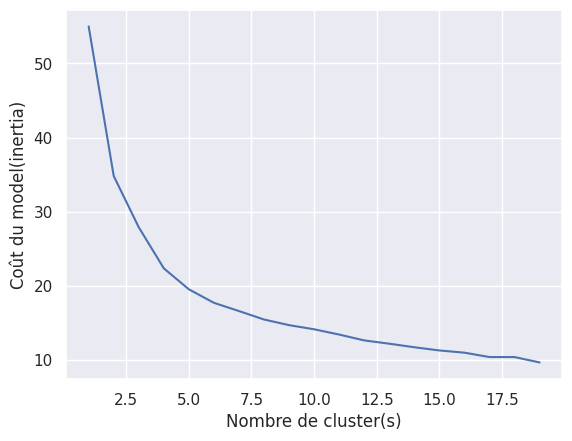

In [ ]:
#Selection du nombre de clusters
from sklearn.cluster import KMeans

inertia = []
k_range = range(1,20)

for k in k_range:
    k_means = KMeans(n_clusters=k)
    k_means.fit(features_normalises)
    inertia.append(k_means.inertia_)

plt.plot(k_range, inertia)
plt.xlabel("Nombre de cluster(s)")
plt.ylabel("Coût du model(inertia)")

In [ ]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(features_normalises)

KMeans(n_clusters=4)

In [ ]:
features_predict = kmeans.predict(features_normalises)
features_predict.shape

(166,)

In [ ]:
#récupérer les coordonnées de tous les points par k-means
groupe_1_index = features[features_predict == 0].index
groupe_2_index = features[features_predict == 1].index
groupe_3_index = features[features_predict == 2].index
groupe_4_index = features[features_predict == 3].index
#groupe_5_index = features[features_predict == 4].index

#création d'un dictionnaire
groupe_1 = [1]* groupe_1_index.shape[0]
groupe_1_dico = dict(zip(groupe_1_index, groupe_1))

groupe_2 = [2]* groupe_2_index.shape[0]
groupe_2_dico = dict(zip(groupe_2_index, groupe_2))

groupe_3 = [3]* groupe_3_index.shape[0]
groupe_3_dico = dict(zip(groupe_3_index, groupe_3))

groupe_4 = [4]* groupe_4_index.shape[0]
groupe_4_dico = dict(zip(groupe_4_index, groupe_4))

#groupe_5 = [5]* groupe_5_index.shape[0]
#groupe_5_dico = dict(zip(groupe_5_index, groupe_4))

dico_groupe = (groupe_1_dico | groupe_2_dico | groupe_3_dico | groupe_4_dico)

In [ ]:
groupe_3_dico

{'Argentina': 3,
 'Belize': 3,
 'Bhutan': 3,
 'Bolivia': 3,
 'Botswana': 3,
 'Brazil': 3,
 'Cambodia': 3,
 'Chile': 3,
 'China': 3,
 'Colombia': 3,
 'Costa Rica': 3,
 'Cyprus': 3,
 'Czech Republic': 3,
 'Dominican Republic': 3,
 'Ecuador': 3,
 'El Salvador': 3,
 'Estonia': 3,
 'Guatemala': 3,
 'Guyana': 3,
 'Honduras': 3,
 'Indonesia': 3,
 'Jamaica': 3,
 'Kazakhstan': 3,
 'Kyrgyzstan': 3,
 'Laos': 3,
 'Libya': 3,
 'Malaysia': 3,
 'Maldives': 3,
 'Malta': 3,
 'Mauritius': 3,
 'Mexico': 3,
 'Myanmar': 3,
 'Namibia': 3,
 'Nicaragua': 3,
 'Oman': 3,
 'Panama': 3,
 'Paraguay': 3,
 'Peru': 3,
 'Philippines': 3,
 'Poland': 3,
 'Portugal': 3,
 'Slovakia': 3,
 'Slovenia': 3,
 'Somalia': 3,
 'South Africa': 3,
 'Spain': 3,
 'Sri Lanka': 3,
 'Suriname': 3,
 'Taiwan Province of China': 3,
 'Thailand': 3,
 'Trinidad and Tobago': 3,
 'Uzbekistan': 3,
 'Venezuela': 3,
 'Vietnam': 3}

In [ ]:

#Import
df_5c = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_5c = df_5c[df_5c["year"] != 2005]
#df_5c = df_5c.dropna(axis = 0, how = "any")
#df_5c = df_5c.merge(df3, on='Country name')
df_5c = df_5c.sort_values(by = "year", ascending = False)
df_5c = df_5c.drop("year", axis = 1)
df_5c

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
1948,Zimbabwe,3.160,7.829,0.717,56.80,0.643,-0.009,0.789,0.703,0.346
578,France,6.714,10.643,0.947,74.20,0.823,-0.169,0.565,0.732,0.231
422,Croatia,6.508,10.166,0.923,71.40,0.837,-0.063,0.961,0.743,0.286
436,Cyprus,6.260,NaN,0.806,74.10,0.763,NaN,0.816,0.759,0.284
1238,New Zealand,7.257,10.600,0.952,73.60,0.918,0.125,0.283,0.849,0.209
...,...,...,...,...,...,...,...,...,...,...
1866,Uzbekistan,5.232,8.193,0.903,61.44,0.784,-0.115,0.609,0.728,0.195
52,Armenia,4.289,9.044,0.682,64.80,0.520,-0.231,0.850,0.494,0.469
875,Kazakhstan,5.476,9.804,0.872,58.20,0.731,-0.274,0.865,0.669,0.185
699,Hong Kong S.A.R. of China,5.511,10.746,0.812,NaN,0.910,0.156,0.356,0.723,0.236


In [ ]:
#remplacer par les pays par les clusters
df_5c["k_means"] = df_5c["Country name"]
df_5c["k_means"] = df_5c["k_means"].replace(dico_groupe)
df_5c["k_means"] = df_5c["k_means"].apply(lambda x : str(x))
df_5c

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,k_means
1948,Zimbabwe,3.160,7.829,0.717,56.80,0.643,-0.009,0.789,0.703,0.346,4
578,France,6.714,10.643,0.947,74.20,0.823,-0.169,0.565,0.732,0.231,1
422,Croatia,6.508,10.166,0.923,71.40,0.837,-0.063,0.961,0.743,0.286,2
436,Cyprus,6.260,NaN,0.806,74.10,0.763,NaN,0.816,0.759,0.284,3
1238,New Zealand,7.257,10.600,0.952,73.60,0.918,0.125,0.283,0.849,0.209,1
...,...,...,...,...,...,...,...,...,...,...,...
1866,Uzbekistan,5.232,8.193,0.903,61.44,0.784,-0.115,0.609,0.728,0.195,3
52,Armenia,4.289,9.044,0.682,64.80,0.520,-0.231,0.850,0.494,0.469,2
875,Kazakhstan,5.476,9.804,0.872,58.20,0.731,-0.274,0.865,0.669,0.185,3
699,Hong Kong S.A.R. of China,5.511,10.746,0.812,NaN,0.910,0.156,0.356,0.723,0.236,1


In [ ]:
df_5c["k_means"].unique()

array(['4', '1', '2', '3'], dtype=object)

In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_5c ['Life Ladder']
X = df_5c.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
# Colonnes catégorielles et numériques
pays_cols = ['Country name']
kmeans_cols = ['k_means']
numeric_cols = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
                'Positive affect', 'Negative affect']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Prétraitement des colonnes catégorielles
pays_transformer = Pipeline(steps=[
    ('targetencoder', TargetEncoder())
])

# Prétraitement des colonnes catégorielles
region_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combiner les prétraitements numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('target', pays_transformer, pays_cols),
        ('hotencoder', region_transformer, kmeans_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

In [ ]:
from sklearn.pipeline import make_pipeline
tree = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))
linear = make_pipeline(preprocessor, LinearRegression())
knn = make_pipeline(preprocessor, KNeighborsRegressor())
svr = make_pipeline(preprocessor, SVR())

from sklearn.model_selection import learning_curve
# Liste des modèles à entrainer
models = [
    ('Arbre de décision', tree),
    ('Regression linéaire', linear),
    ('KNN', knn),
    ('SVR', svr),
]

# Pipeline complète pour chaque modèle
for model_name, model in models:

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    #Performance du modèles
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test,y_test)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test)


    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

Model: Arbre de décision
Performances sur le jeu train: 1.0
Performances sur le jeu test: 0.8317512448375562
MAE: 0.33453506493506496
RMSE: 0.4482817991270351
--------------------------
Model: Regression linéaire
Performances sur le jeu train: 0.8808084515145022
Performances sur le jeu test: 0.8448345848905423
MAE: 0.3303549512987013
RMSE: 0.43049948895010637
--------------------------
Model: KNN
Performances sur le jeu train: 0.9321810541973475
Performances sur le jeu test: 0.8802751717421011
MAE: 0.27826129870129873
RMSE: 0.3781527715743343
--------------------------
Model: SVR
Performances sur le jeu train: 0.879905285156939
Performances sur le jeu test: 0.8429464516252645
MAE: 0.3322652836272263
RMSE: 0.43311083945872697
--------------------------


##Procédure d'évaluation

In [ ]:
"""
Objectifs :
- rendre la procédure d'évaluation robuste
- matérialiser le type d'erreurs car ce n'est pas parce que le score est bon que les erreurs ne sont pas graves
"""

"\nObjectifs :\n- rendre la procédure d'évaluation robuste\n- matérialiser le type d'erreurs car ce n'est pas parce que le score est bon que les erreurs ne sont pas graves\n"

####Test n°6b - double vérification

In [ ]:
"""
Utiliser le jeu 2021 pour valider la procédure
"""

'\nUtiliser le jeu 2021 pour valider la procédure\n'

In [ ]:
# Optimisation GridSearchCV targetencoder pays + onehot sur région
!pip install category_encoders
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

Model: Arbre de décision
Performances sur le jeu train: 1.0
Performances sur le jeu test: 0.8417013985543792
MAE: 0.3222258064516129
RMSE: 0.4419454121402642
--------------------------
Model: Regression linéaire
Performances sur le jeu train: 0.8789493843709126
Performances sur le jeu test: 0.8801823831143964
MAE: 0.305629900429909
RMSE: 0.38449476361561713
--------------------------
Model: KNN
Performances sur le jeu train: 0.9166343112142419
Performances sur le jeu test: 0.8943027075038547
MAE: 0.27491720430107525
RMSE: 0.3611287147294584
--------------------------
Model: SVR
Performances sur le jeu train: 0.8810298146448208
Performances sur le jeu test: 0.883998107393218
MAE: 0.2915679774426039
RMSE: 0.3783228984863252
--------------------------


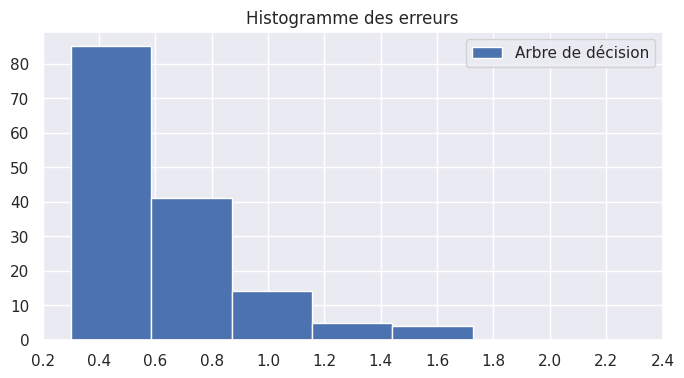

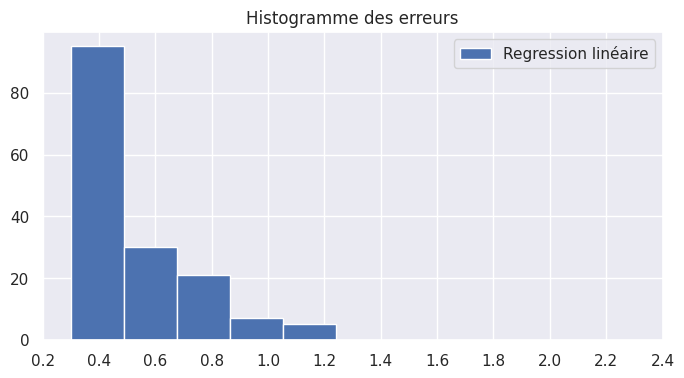

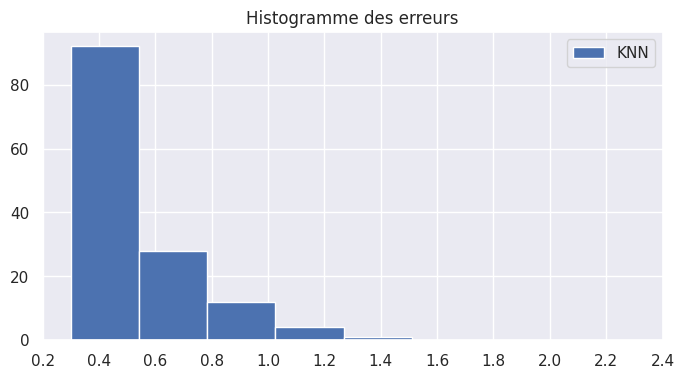

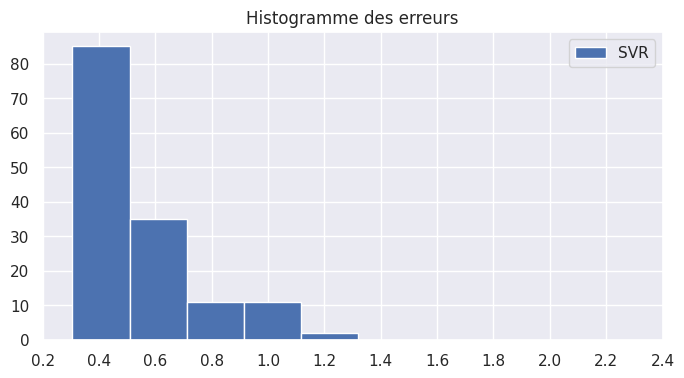

In [ ]:
#Import
df = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df = df.merge(df3, on='Country name')
df = df[df["year"] != 2005]
df_final = df.sort_values(by = "year", ascending = False)
df_final = df_final.drop("year", axis = 1)

# Division des données en ensembles d'entraînement et de test
y = df_final ['Life Ladder']
X = df_final.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Colonnes catégorielles et numériques
pays_cols = ['Country name']
region_cols = ['Regional indicator']
numeric_cols = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
                'Positive affect', 'Negative affect', ]

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Prétraitement des colonnes catégorielles
pays_transformer = Pipeline(steps=[
    ('targetencoder', TargetEncoder())
])

# Prétraitement des colonnes catégorielles
region_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combiner les prétraitements numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('target', pays_transformer, pays_cols),
        ('hotencoder', region_transformer, region_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

from sklearn.pipeline import make_pipeline
tree = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))
linear = make_pipeline(preprocessor, LinearRegression())
knn = make_pipeline(preprocessor, KNeighborsRegressor())
svr = make_pipeline(preprocessor, SVR())

from sklearn.model_selection import learning_curve
# Liste des modèles à entrainer
models = [
    ('Arbre de décision', tree),
    ('Regression linéaire', linear),
    ('KNN', knn),
    ('SVR', svr),
]

# Pipeline complète pour chaque modèle
for model_name, model in models:

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    #Performance du modèles
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test,y_test)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

    #Histogrammes des erreurs
    plt.figure(figsize = (8,4))
    err_hist = np.abs(y_test - y_pred)
    err_hist_tol = []
    for erreur in err_hist:
      if erreur >= 0.3:
        err_hist_tol.append(erreur)
    plt.hist(err_hist_tol, label = model_name, bins = 5)
    plt.title("Histogramme des erreurs")

    plt.xticks([0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4])
    plt.legend();

In [ ]:
"""
Nous concluons cette première partie avec le pré-processing déterminé lors du test n°4c :

    Encodage de la variable “pays” par un targetEncoder

    Suppression de la variable “année”

    Standardisation des valeurs numériques

    Remplacement des Nans par un imputer



Nous gardons en mémoire que :

    L’”année” a été supprimée par des soucis de généralisation du modèle et non de performance

    Le KNN peut être plus performant avec un Min Max et l’intégrerons dans notre procédure d’évaluation lors de la modélisation.



A cette étape du process, nous constatons que :

    L'arbre de décision souffre de sur-apprentissage

    La régression linéaire a dû mal à s’adapter à notre jeu de données

    Le KNN et le SVM sont les plus performants. Cependant, le KNN semble faire moins de grosses erreurs.
"""

"\nNous concluons cette première partie avec le pré-processing déterminé lors du test n°4c :\n\n    Encodage de la variable “pays” par un targetEncoder\n\n    Suppression de la variable “année”\n\n    Standardisation des valeurs numériques\n\n    Remplacement des Nans par un imputer\n\n\n\nNous gardons en mémoire que :\n\n    L’”année” a été supprimée par des soucis de généralisation du modèle et non de performance\n\n    Le KNN peut être plus performant avec un Min Max et l’intégrerons dans notre procédure d’évaluation lors de la modélisation.\n\n\n\nA cette étape du process, nous constatons que :\n\n    L'arbre de décision souffre de sur-apprentissage\n\n    La régression linéaire a dû mal à s’adapter à notre jeu de données\n\n    Le KNN et le SVM sont les plus performants. Cependant, le KNN semble faire moins de grosses erreurs.\n"

##Optimisation par un grid Search

In [ ]:
# Optimisation GridSearchCV targetencoder pays + onehot sur région
!pip install category_encoders
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
df_SVM = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_SVM = df_SVM[df_SVM["year"] != 2005]
df_SVM = df_SVM.sort_values(by = "year", ascending = False)
df_SVM = df_SVM.drop(["year"], axis = 1)

df_SVM = df_SVM.merge(df3, on='Country name')
#df_SVM = df_SVM.dropna(axis = 0, how = "any")

#remplacer par les pays par les clusters
#df_SVM["k_means"] = df_SVM["Country name"]
#df_SVM["k_means"] = df_SVM["k_means"].replace(dico_groupe)
#df_SVM["k_means"] = df_SVM["k_means"].apply(lambda x : str(x))

# Division des données en ensembles d'entraînement et de test
y = df_SVM ['Life Ladder']
X = df_SVM.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Gestion des Nan
col_numeric = ["Log GDP per capita", "Social support",'Healthy life expectancy at birth',
               "Freedom to make life choices", "Generosity", "Perceptions of corruption",
               "Positive affect", "Negative affect"]

def gestion_nan1(X):
  for colonne in col_numeric:
    if 'Regional indicator' in X.columns:
      X[colonne] = X[colonne].fillna(X.groupby("Regional indicator")[colonne].transform('median'))

  X_new = X.drop("Regional indicator", axis = 1)

  return X

gestion_nan1(X_train)
gestion_nan1(X_test)

# Colonnes catégorielles et numériques
pays_cols = ['Country name']
cluster_cols = ['Regional indicator']
numeric_cols = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
                'Positive affect']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
     ('scaler', StandardScaler())
])

# Prétraitement des colonnes catégorielles
pays_transformer = Pipeline(steps=[
    ('targetencoder', TargetEncoder())
])

# Prétraitement des colonnes catégorielles
region_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combiner les prétraitements numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('target', pays_transformer, pays_cols),
        ('hotencoder', region_transformer, cluster_cols),
        ('num', numeric_transformer, numeric_cols)
    ])


# Modèles
svr = Pipeline([
    ('preprocessor', preprocessor),
     ('regressor', SVR())
])

# Liste des modèles à entraîner
models = [
    ('svr', svr)
]

# Dictionnaire des grilles de paramètres pour chaque modèle
param_grids = {
    'SVR': {
        'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'regressor__C': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, 20, 23, 26, 29, 30],
    }
}

# Boucle pour chaque modèle
for model_name, model in models:
    # Obtenez la grille de paramètres correspondante
    param_grid = param_grids.get(model_name, {})

    # Créez un pipeline pour le modèle avec recherche par grille
    model_with_gridsearch = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Entraînez le modèle avec recherche par grille sur les données d'entraînement
    model_with_gridsearch.fit(X_train, y_train)

    # Obtenez les meilleurs paramètres et la meilleure performance
    best_params = model_with_gridsearch.best_params_

    # Affichage des meilleurs paramètres et de la meilleure performance
    print(f"Meilleurs paramètres pour le modèle {model_name}: {best_params}")

    # Utilisez les meilleurs paramètres pour initialiser le modèle
    best_model = model.set_params(**best_params)

    # Entraînez le meilleur modèle sur les données d'entraînement
    best_model.fit(X_train, y_train)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = best_model.predict(X_test)

    #Calcul des métriques sélectionnées
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des meilleurs paramètres, de la meilleure performance et des métriques
    print(f"Modèle: {model_name}")
    print(f"Meilleurs paramètres: {best_params}")
    #print(f"Meilleure performance (négative MSE) : {best_score}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

Meilleurs paramètres pour le modèle svr: {}
Modèle: svr
Meilleurs paramètres: {}
MAE: 0.30653891087143076
RMSE: 0.403178882295624
--------------------------


####Modèles de type "arbres"

In [ ]:
def rmse_revu(y_true, y_pred, threshold = 0.3):
  errors = np.abs(y_true - y_pred)
  squared_errors = np.where(errors > threshold, errors**2 , 0)
  mean_squared_error = np.mean(squared_errors)
  final_score = np.sqrt(mean_squared_error)
  return final_score

In [ ]:
"""
Les réglages réalisés :
- suppression des nan dans le trainset
- max_depth fixé
"""

'\nLes réglages réalisés :\n- suppression des nan dans le trainset\n- max_depth fixé\n'

#####Pré-processing

In [ ]:
#Import

df_ensemble = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_ensemble = df_ensemble[df_ensemble["year"] != 2005] #OK
df_ensemble = df_ensemble.sort_values(by = "year", ascending = False) #OK
df_ensemble = df_ensemble.drop(["year"], axis = 1) #OK

#df_ensemble = df_ensemble.dropna(axis = 0, how = "any")

#Ajout de la variable "Regional indicator" pour le remplacement des Nans
df_ensemble = df_ensemble.merge(df3, on='Country name') #OK

#Ajout d'une caractéristique dérivée
#df_ensemble["k_means"] = df_ensemble["Country name"]
#df_ensemble["k_means"] = df_ensemble["k_means"].replace(dico_groupe)
#df_ensemble["k_means"] = df_ensemble["k_means"].apply(lambda x : str(x))

# Division des données en ensembles d'entraînement et de test
y = df_ensemble ['Life Ladder']
X = df_ensemble.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42) #OK


# Colonnes catégorielles et numériques
cat_cols = ['Country name']
regions_cols = ['Regional indicator']
numeric_cols = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                'Freedom to make life choices', 'Perceptions of corruption','Generosity',
                'Positive affect', 'Negative affect']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')) #OK
])

# Prétraitement des colonnes catégorielles
pays_transformer = Pipeline(steps=[
    ('targetencoder', TargetEncoder()) #OK
])

# Prétraitement des colonnes catégorielles
region_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder()) #OK
])

# Combiner les prétraitements numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('target', pays_transformer, cat_cols),
        ('hotencoder', region_transformer, regions_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

#####Modelisation avant optimisation

In [ ]:
from sklearn.pipeline import make_pipeline
tree_avt_optim = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))
random_avt_optim = make_pipeline(preprocessor, RandomForestRegressor(random_state=42))
adaboost_avt_optim = make_pipeline(preprocessor, AdaBoostRegressor(RandomForestRegressor(random_state=42)))

# Liste des modèles à entrainer
models = [
    ('Arbre de décision', tree_avt_optim),
    #('Random Forest', random_avt_optim),
    #('Adaboost', adaboost_avt_optim)
]
from sklearn.base import clone

# Pipeline complète pour chaque modèle
for model_name, model in models:
    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

Model: Arbre de décision
Performances sur le jeu train: 0.8810298146448208
Performances sur le jeu test: 0.883998107393218
MAE: 0.3325456989247312
RMSE: 0.4513693115136917
--------------------------


In [ ]:
df2_ensemble = pd.read_excel("world-happiness-report-2022.xls")

#Mise en forme
df2_ensemble = df2_ensemble[df2_ensemble["year"] == 2021]

#ajouter la région
df2_ensemble = df2_ensemble.merge(df3, on='Country name')

#ajout k_means
#df2_ensemble["k_means"] = df2_ensemble["Country name"]
#df2_ensemble["k_means"] = df2_ensemble["k_means"].replace(dico_groupe)
#df2_ensemble["k_means"] = df2_ensemble["k_means"].apply(lambda x : str(x))

#suppression année et générosité
df2_ensemble = df2_ensemble.drop(["Confidence in national government", "year"], axis = 1)

# Séparation de la variable cible des fonctionnalités
y_2021_ensemble = df2_ensemble['Life Ladder']
X_2021_ensemble = df2_ensemble.drop(columns=['Life Ladder'])

In [ ]:
for model_name, model in models:

    # Prédictions des valeurs sur l'ensemble de test
    y_pred_ensemble_2021 = model.predict(X_2021_ensemble)

    # Calcul des métriques
    mae = mean_absolute_error(y_pred_ensemble_2021, y_2021_ensemble)
    rmse = mean_squared_error(y_pred_ensemble_2021, y_2021_ensemble, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

    print("\n")

Model: Arbre de décision
MAE: 0.39629254827661026
RMSE: 0.5325637866693137
--------------------------




#####Optimisation

In [ ]:
# Modèles
tree = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

randomforest = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Liste des modèles à entraîner
models = [
    ('Arbre de décision', tree),
    ('Random Forest', randomforest)
]

# Dictionnaire des grilles de paramètres pour chaque modèle
param_grids = {
    'Arbre de décision': {
        'regressor__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,20],
        'regressor__min_samples_split': [1,2,3,4,5,6]
    },

    'Random Forest': {
        'regressor__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,20],
          'regressor__min_samples_split': [1,2,3,4,5,6],
    },

    }


# Boucle pour chaque modèle
for model_name, model in models:
    # Obtenez la grille de paramètres correspondante
    param_grid = param_grids.get(model_name, {})

    # Créez un pipeline pour le modèle avec recherche par grille
    model_with_gridsearch = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Entraînez le modèle avec recherche par grille sur les données d'entraînement
    model_with_gridsearch.fit(X_train, y_train)

    # Obtenez les meilleurs paramètres et la meilleure performance
    best_params = model_with_gridsearch.best_params_

    # Affichage des meilleurs paramètres et de la meilleure performance
    print(f"Meilleurs paramètres pour le modèle {model_name}: {best_params}")

    # Utilisez les meilleurs paramètres pour initialiser le modèle
    best_model = model.set_params(**best_params)

    # Entraînez le meilleur modèle sur les données d'entraînement
    best_model.fit(X_train, y_train)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = best_model.predict(X_test)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # Affichage des meilleurs paramètres, de la meilleure performance et des métriques
    print(f"Modèle: {model_name}")
    print(f"Meilleurs paramètres: {best_params}")
    #print(f"Meilleure performance (négative MSE) : {best_score}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R2 Score: {r2}")
    print("--------------------------")

#####Modelisation après optimisation

In [ ]:
from sklearn.pipeline import make_pipeline
tree_ap_optim = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42, max_depth = 6, min_samples_split = 3)) #OK
random_ap_optim = make_pipeline(preprocessor, RandomForestRegressor(random_state=42, max_depth = 16, min_samples_split = 7)) #OK
adaboost_ap_optim = make_pipeline(preprocessor, RandomForestRegressor(random_state=42, max_depth = 16, min_samples_split = 7)) #OK

# Liste des modèles à entrainer
models = [
    ('Arbre de décision', tree_ap_optim),
    ('Random Forest', random_ap_optim),
    ('Adaboost', adaboost_ap_optim)
]
from sklearn.base import clone

# Pipeline complète pour chaque modèle
for model_name, model in models:
    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

#####Prédiction

In [ ]:
df2_ensemble_optim = pd.read_excel("world-happiness-report-2022.xls")

#Mise en forme
df2_ensemble_optim = df2_ensemble_optim[df2_ensemble_optim["year"] == 2021]

#ajouter la région
df2_ensemble_optim = df2_ensemble_optim.merge(df3, on='Country name')

#ajout k_means
#df2_ensemble_optim["k_means"] = df2_ensemble_optim["Country name"]
#df2_ensemble_optim["k_means"] = df2_ensemble_optim["k_means"].replace(dico_groupe)
#df2_ensemble_optim["k_means"] = df2_ensemble_optim["k_means"].apply(lambda x : str(x))

#suppression année et générosité
df2_ensemble_optim = df2_ensemble_optim.drop(["Confidence in national government", "year"], axis = 1)

# Séparation de la variable cible des fonctionnalités
y_2021_ensemble_optim = df2_ensemble_optim['Life Ladder']
X_2021_ensemble_optim = df2_ensemble_optim.drop(columns=['Life Ladder'])

In [ ]:
for model_name, model in models:

    # Prédictions des valeurs sur l'ensemble de test
    y_pred_ensemble_2021_optim = model.predict(X_2021_ensemble_optim)

    # Calcul des métriques
    mae = mean_absolute_error(y_pred_ensemble_2021_optim, y_2021_ensemble_optim)
    rmse = mean_squared_error(y_pred_ensemble_2021_optim, y_2021_ensemble_optim, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

    print("\n")

    #Histogrammes des erreurs
    plt.figure(figsize = (8,4))
    err_hist = np.abs(y_pred_ensemble_2021_optim - y_2021_ensemble_optim)
    err_hist_tol = []
    for erreur in err_hist:
      if erreur >= 0.3:
        err_hist_tol.append(erreur)
    plt.title("Histogramme des erreurs")
    plt.hist(err_hist_tol, label = model_name, bins = 5)
    plt.xticks([0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4])
    plt.legend();

In [ ]:
"""
Le Random apporte de vraies améliorations par rapport à un arbre seul.
Même s’il reste lui-même en sur-apprentissage, il s’adapte beaucoup mieux aux diversités de relations qu’il existe dans notre jeu de données grâce à la combinaison de plusieurs arbres.

En revanche, l’Adaboost n’a rien apporté au Random, ce qui peut être révélateur d’échantillons plutôt bien classés.

"""

#####Ordre d'importance des variables

In [ ]:
#Import

df_ensemble = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_ensemble = df_ensemble[df_ensemble["year"] != 2005]
df_ensemble = df_ensemble.sort_values(by = "year", ascending = False)
df_ensemble = df_ensemble.drop(["year"], axis = 1)

#df_ensemble = df_ensemble.dropna(axis = 0, how = "any")

#Ajout de la variable "Regional indicator" pour le remplacement des Nans
df_ensemble = df_ensemble.merge(df3, on='Country name')

#Ajout d'une caractéristique dérivée
#df_ensemble["k_means"] = df_ensemble["Country name"]
#df_ensemble["k_means"] = df_ensemble["k_means"].replace(dico_groupe)
#df_ensemble["k_means"] = df_ensemble["k_means"].apply(lambda x : str(x))

# Division des données en ensembles d'entraînement et de test
y = df_ensemble ['Life Ladder']
X = df_ensemble.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


# Colonnes catégorielles et numériques
cat_cols = ['Country name']
regions_cols = ['Regional indicator']
numeric_cols = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                'Freedom to make life choices', 'Perceptions of corruption','Generosity',
                'Positive affect', 'Negative affect']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Prétraitement des colonnes catégorielles
pays_transformer = Pipeline(steps=[
    ('targetencoder', TargetEncoder())
])

# Prétraitement des colonnes catégorielles
region_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combiner les prétraitements numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('target', pays_transformer, cat_cols),
        ('hotencoder', region_transformer, regions_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

In [ ]:
random_ap_optim = make_pipeline(preprocessor, RandomForestRegressor(random_state=42, max_depth = 16, min_samples_split = 7))

In [ ]:
random_ap_optim.fit(X_train, y_train)

In [ ]:
print(random_ap_optim.named_steps.keys())

In [ ]:
X_train.columns

In [ ]:
features = random_ap_optim.named_steps['randomforestregressor'].feature_importances_
print(features)

#####Régions bien prédites

In [ ]:
X_2021_ensemble_predict = random_ap_optim.predict(X_2021_ensemble_optim)
ecart_ensemble_optim = abs(X_2021_ensemble_predict - y_2021_ensemble_optim)
ecart_ensemble_optim

In [ ]:
ecart_ensemble_optim_df = ecart_ensemble_optim.to_frame(name='Ecarts')
ecart_ensemble_optim_df

In [ ]:
ecart_ensemble_optim_df["Regional indicator"] = X_2021_ensemble_optim["Regional indicator"]
ecart_ensemble_optim_df

In [ ]:
bonnes_reponses = ecart_ensemble_optim_df[ecart_ensemble_optim_df["Ecarts"] < 0.3]
bonnes_reponses = bonnes_reponses["Regional indicator"].value_counts()
bonnes_reponses

In [ ]:
nb_pays_region

In [ ]:
pourcentage_bonnes_reponses = ((bonnes_reponses/nb_pays_region)*100).sort_values(ascending = False)
pourcentage_bonnes_reponses

####Modèles de type "linéaire"

In [ ]:
"""
Les modèles de type ensemble ne semblent pas adaptés à notre jeu de données
puisque nous constatons une forte différence de performance entre le jeu d'entraînement et le jeu test

L'avantage d'un modèle paramétrique, c'est qu'il est de forme analytique
et peut être plus performant sur un jeu de données avec une distribution normale

L'objectif de cette modélisation :
- comprendre le type de linéarité
- voir si une régularisation permet une optimisation du modèle
"""

#####Pré-processing

In [ ]:
df_lineaire = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_lineaire = df_lineaire[df_lineaire["year"] != 2005]
df_lineaire = df_lineaire.sort_values(by = "year", ascending = False)
df_lineaire = df_lineaire.drop(["year"], axis = 1)

In [ ]:

#Import
df_lineaire = df_lineaire.merge(df3, on='Country name')
#df_lineaire = df_lineaire.dropna(axis = 0, how = "any")

df_lineaire["k_means"] = df_lineaire["Country name"]
df_lineaire["k_means"] = df_lineaire["k_means"].replace(dico_groupe)
df_lineaire["k_means"] = df_lineaire["k_means"].apply(lambda x : str(x))

# Division des données en ensembles d'entraînement et de test
y = df_lineaire ['Life Ladder']
X = df_lineaire.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)


col_numeric = ["Log GDP per capita", "Social support",'Healthy life expectancy at birth',
               "Freedom to make life choices", "Generosity", "Perceptions of corruption",
               "Positive affect", "Negative affect"]

def gestion_nan1(X):
  for colonne in col_numeric:
    if 'Regional indicator' in X.columns:
      X[colonne] = X[colonne].fillna(X.groupby("Regional indicator")[colonne].transform('median'))

  X_new = X.drop("Regional indicator", axis = 1)

  return X_new

gestion_nan1(X_train)
gestion_nan1(X_test)

# Colonnes catégorielles et numériques
pays_cols = ['Country name']
k_means_cols = ['k_means']
numeric_cols = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
                'Positive affect', 'Negative affect']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Prétraitement des colonnes catégorielles
pays_transformer = Pipeline(steps=[
    ('targetencoder', TargetEncoder())
])

# Prétraitement des colonnes catégorielles
region_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combiner les prétraitements numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('target', pays_transformer, pays_cols),
       ('hotencoder', region_transformer, k_means_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

#####Modelisation

In [ ]:
from sklearn.pipeline import make_pipeline

linear = make_pipeline(preprocessor, LinearRegression())
ridge = make_pipeline(preprocessor, Ridge(alpha = 1, solver = "sag" )) #corrélation entre les variables qui ne necessitent pas de revoir le poids des variables
lasso = make_pipeline(preprocessor, Lasso(alpha = 0.1)) #avec un alpha a 0.1, le modèle ressemble à une régression linéaire standard ==> inutile car pas de grosses corélations entre les variables et pas de nécessité de mettre à 0 certaines variables

In [ ]:
# Liste des modèles à entrainer
models = [
    ('Linear Regression', linear),
    ('Ridge', ridge),
    ('Lasso', lasso),
]
from sklearn.base import clone

# Pipeline complète pour chaque modèle
for model_name, model in models:
    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

#####Prédiction

In [ ]:
df2_lineaire = pd.read_excel("world-happiness-report-2022.xls")

#Mise en forme
df2_lineaire = df2_lineaire[df2_lineaire["year"] == 2021]

#ajouter la région
df2_lineaire = df2_lineaire.merge(df3, on='Country name')

df2_lineaire["k_means"] = df2_lineaire["Country name"]
df2_lineaire["k_means"] = df2_lineaire["k_means"].replace(dico_groupe)
df2_lineaire["k_means"] = df2_lineaire["k_means"].apply(lambda x : str(x))

#suppression année et générosité
df2_lineaire = df2_lineaire.drop(["Confidence in national government", "year"], axis = 1)

# Séparation de la variable cible des fonctionnalités
y_2021_lineaire = df2_lineaire['Life Ladder']
X_2021_lineaire = df2_lineaire.drop(columns=['Life Ladder'])

In [ ]:
col_numeric = ["Log GDP per capita", "Social support",'Healthy life expectancy at birth',
               "Freedom to make life choices", "Generosity", "Perceptions of corruption",
               "Positive affect", "Negative affect"]

def gestion_nan1(X):
  for colonne in col_numeric:
    if 'Regional indicator' in X.columns:
      X[colonne] = X[colonne].fillna(X.groupby("Regional indicator")[colonne].transform('median'))

  X_new = X.drop("Regional indicator", axis = 1)

  return X_new

gestion_nan1(X_2021_lineaire)

In [ ]:
for model_name, model in models:

    # Prédictions des valeurs sur l'ensemble de test
    y_pred_2021_lineaire = model.predict(X_2021_lineaire)

    # Calcul des métriques
    mae = mean_absolute_error(y_pred_2021_lineaire, y_2021_lineaire)
    rmse = mean_squared_error(y_pred_2021_lineaire, y_2021_lineaire, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

    print("\n")

    #Histogrammes des erreurs
    plt.figure(figsize = (8,4))
    err_hist_lineaire = np.abs(y_2021_lineaire - y_pred_2021_lineaire)
    err_hist_tol_lin = []
    for erreur in err_hist_lineaire:
      if erreur >= 0.3:
        err_hist_tol_lin.append(erreur)
    plt.hist(err_hist_tol_lin, label = model_name, bins = 5)
    plt.title("Histogramme des erreurs")

    plt.xticks([0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4])
    plt.legend();

In [ ]:
"""
En fin de compte, le modèle linéaire ne nécessite pas de régularisation

Ridge avec un alpha = 0.9, c'est l'équivalent d'une régression linéaire
La régression Ridge, également appelée régression Ridge pénalisée, est une technique utilisée en statistiques et en apprentissage automatique
pour traiter le problème de multicollinéarité dans les modèles de régression linéaire.
Le Ridge ajoute une pénalité à la fonction de coût de la régression linéaire standard.
Cette pénalité encourage les coefficients des variables les moins importantes à se rapprocher de zéro,

Lasso avec un alpha = 0.1, c'est l'équivalent d'une régression linéaire
Tout comme la régression Ridge, le Lasso est conçu pour traiter le problème de multicollinéarité dans les modèles de régression linéaire.
Contrairement à la régression Ridge qui utilise la somme des carrés des coefficients comme pénalité, le Lasso utilise la somme des valeurs absolues des coefficients.
Cela signifie que dans le Lasso, certains coefficients peuvent être exactement égaux à zéro,

==> pas de collinéralité. Pas de nécéssité de ré-ajuster le poids des variables

Sans hyper-paramètres, la regression linéaire a de moins bonnes performances que le Random et l'Adaboost
et est tout autant en sur-apprentissage.

"""

#####Variables utilisées par Ridge

In [ ]:
df_lineaire = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_lineaire = df_lineaire[df_lineaire["year"] != 2005]
df_lineaire = df_lineaire.sort_values(by = "year", ascending = False)
df_lineaire = df_lineaire.drop(["year"], axis = 1)

df_lineaire = df_lineaire.merge(df3, on='Country name')
#df_lineaire = df_lineaire.dropna(axis = 0, how = "any")

df_lineaire["k_means"] = df_lineaire["Country name"]
df_lineaire["k_means"] = df_lineaire["k_means"].replace(dico_groupe)
df_lineaire["k_means"] = df_lineaire["k_means"].apply(lambda x : str(x))

# Division des données en ensembles d'entraînement et de test
y = df_lineaire ['Life Ladder']
X = df_lineaire.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)


col_numeric = ["Log GDP per capita", "Social support",'Healthy life expectancy at birth',
               "Freedom to make life choices", "Generosity", "Perceptions of corruption",
               "Positive affect", "Negative affect"]

def gestion_nan1(X):
  for colonne in col_numeric:
    if 'Regional indicator' in X.columns:
      X[colonne] = X[colonne].fillna(X.groupby("Regional indicator")[colonne].transform('median'))

  X_new = X.drop("Regional indicator", axis = 1)

  return X_new

X_train_ridge = gestion_nan1(X_train)
X_test_ridge = gestion_nan1(X_test)

In [ ]:


# Colonnes catégorielles et numériques
pays_cols = ['Country name']
k_means_cols = ['k_means']
numeric_cols = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
                'Positive affect', 'Negative affect']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Prétraitement des colonnes catégorielles
pays_transformer = Pipeline(steps=[
    ('targetencoder', TargetEncoder())
])

# Prétraitement des colonnes catégorielles
region_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combiner les prétraitements numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('target', pays_transformer, pays_cols),
       ('hotencoder', region_transformer, k_means_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

In [ ]:
ridge = make_pipeline(preprocessor, Ridge(alpha = 1, solver = "sag" ))

In [ ]:
ridge.fit(X_train_ridge, y_train)

In [ ]:
X_train_ridge.columns

In [ ]:
coefficients = ridge.named_steps['ridge'].coef_
print(coefficients)


#####Régions bien prédites

In [ ]:
X_2021_lineaire_predict = ridge.predict(X_2021_lineaire)
ecart_lineaire_optim = abs(X_2021_lineaire_predict - y_2021_lineaire)

ecart_lineaire_optim_df = ecart_lineaire_optim.to_frame(name='Ecarts')

ecart_lineaire_optim_df["Regional indicator"] = X_2021_lineaire["Regional indicator"]

bonnes_reponses_lineaire = ecart_lineaire_optim_df[ecart_lineaire_optim_df["Ecarts"] < 0.3]
bonnes_reponses_lineaire = bonnes_reponses_lineaire["Regional indicator"].value_counts()

pourcentage_bonnes_reponses_lin = ((bonnes_reponses_lineaire/nb_pays_region)*100).sort_values(ascending = False)
pourcentage_bonnes_reponses_lin

####KNN

#####Pré-processing

In [ ]:
"""
Le KNN est un algo non paramétrique.
Il se base plus sur l'observation que sur les calculs.
De ce fait, afin de le rendre performant, nous avons volontairement augmenter l'espace d'apprentissage

Ajout d'un MinMax en lieu et place d'un StandardScaler

Plus performant avec les variables catégorielles encodées avec un TargetEncoder

Dans le cas de notre dataset, son fonctionnement se basera sur les 3 voisins les plus proches suivant une distance "manhattan"
La distance Manhattan a de meilleure performance (malgré le temps de calcul) que l'euclidienne, ce qui peut révéler la présence de outliers
n_neighbors = 3, metric = "manhattan"
"""

In [ ]:
#Import
df_KNN = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_KNN = df_KNN[df_KNN["year"] != 2005]
df_KNN = df_KNN.sort_values(by = "year", ascending = False)
df_KNN = df_KNN.drop("year", axis = 1)

df_KNN = df_KNN.merge(df3, on='Country name')

#df_KNN = df_KNN.dropna(axis = 0, how = "any")

#remplacer par les pays par les clusters
#df_KNN["k_means"] = df_KNN["Country name"]
#df_KNN["k_means"] = df_KNN["k_means"].replace(dico_groupe)
#df_KNN["k_means"] = df_KNN["k_means"].apply(lambda x : str(x))

In [ ]:
# Division des données en ensembles d'entraînement et de test
y = df_KNN ['Life Ladder']
X = df_KNN.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)


# Colonnes catégorielles et numériques
pays_cols = ['Country name']
cluster_cols = ['Regional indicator']
numeric_cols = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
                'Positive affect', 'Negative affect']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Prétraitement des colonnes catégorielles
pays_transformer = Pipeline(steps=[
    ('targetencoder', TargetEncoder())
])

# Prétraitement des colonnes catégorielles
region_transformer = Pipeline(steps=[
    ('onehot', TargetEncoder())
])

# Combiner les prétraitements numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('target', pays_transformer, pays_cols),
        ('hotencoder', region_transformer, cluster_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

#####Modelisation

In [ ]:
knn = make_pipeline(preprocessor, KNeighborsRegressor(n_neighbors = 3, metric = "manhattan")) #optimisation du nombre de voisins


In [ ]:
# Liste des modèles à entrainer
models = [
    ('KNN', knn)
]
from sklearn.base import clone

# Pipeline complète pour chaque modèle
for model_name, model in models:
    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

#####Prédiction

In [ ]:
df2_KNN = pd.read_excel("world-happiness-report-2022.xls")

In [ ]:
#Mise en forme
df2_KNN = df2_KNN[df2_KNN["year"] == 2021]

#suppression année
df2_KNN = df2_KNN.drop(["Confidence in national government", "year"], axis = 1)

#ajouter la région
df2_KNN = df2_KNN.merge(df3, on='Country name')

#remplacer par les pays par les clusters
#df2_KNN["k_means"] = df2_KNN["Country name"]
#df2_KNN["k_means"] = df2_KNN["k_means"].replace(dico_groupe)
#df2_KNN["k_means"] = df2_KNN["k_means"].apply(lambda x : str(x))

# Séparation de la variable cible des fonctionnalités
y_2021_knn = df2_KNN['Life Ladder']
X_2021_knn = df2_KNN.drop(columns=['Life Ladder'])

In [ ]:
for model_name, model in models:

    # Prédictions des valeurs sur l'ensemble de test
    y_pred_2021_knn = model.predict(X_2021_knn)

    # Calcul des métriques
    mae = mean_absolute_error(y_pred_2021_knn, y_2021_knn)
    rmse = mean_squared_error(y_pred_2021_knn, y_2021_knn, squared=False)
    RMSE_REVU = rmse_revu(y_pred_2021_knn, y_2021_knn)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

    print("\n")

    #Histogrammes des erreurs
    plt.figure(figsize = (8,4))
    err_hist = np.abs(y_2021_knn - y_pred_2021_knn)
    err_hist_tol = []
    for erreur in err_hist:
      if erreur >= 0.3:
        err_hist_tol.append(erreur)
    plt.hist(err_hist_tol, label = model_name, bins = 5)
    plt.title("Histogramme des erreurs")

    plt.xticks([0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4])
    plt.legend();

In [ ]:
"""
Il n’est pas surprenant de voir le KNN briller là où la régression linéaire a échoué.

Le modèle se généralise très bien et fait peu de gros écarts de prédiction.
"""

#####Interprétations

In [ ]:
"""
impossible à savoir

il ne retient que les points de données d'entraînement avec leurs caractéristiques associées.
Lorsqu'il effectue une prédiction pour un nouveau point, il utilise les mêmes caractéristiques pour calculer les distances
et trouver les voisins les plus proches. Par conséquent, bien qu'à chaque prédiction le modèle k-NN utilise les caractéristiques des k voisins les plus proches, il ne fournit pas d'informations précises sur les variables individuelles utilisées pour chaque prédiction.
"""

In [ ]:
knn.fit(X_train, y_train)

#####Régions bien prédites

In [ ]:
X_2021_knn_predict = knn.predict(X_2021_knn)
ecart_knn_optim = abs(X_2021_knn_predict - y_2021_knn)

ecart_knn_optim_df = ecart_knn_optim.to_frame(name='Ecarts')

ecart_knn_optim_df["Regional indicator"] = X_2021_knn["Regional indicator"]

bonnes_reponses_knn = ecart_knn_optim_df[ecart_knn_optim_df["Ecarts"] < 0.3]
bonnes_reponses_knn = bonnes_reponses_knn["Regional indicator"].value_counts()

pourcentage_bonnes_reponses_knn = ((bonnes_reponses_knn/nb_pays_region)*100).sort_values(ascending = False)
pourcentage_bonnes_reponses_knn

####Support Vector Machine

In [ ]:
"""
L'intérêt de ce modèle, c'est qu'il peut séparer une jeu de données de type gaussien (et strictement non linéaire)
et jouer sur compromis biais/variance grâce à l'hyperparamètre C

pas de changement dans le pré-processing

"""

#####Pré-processing

In [ ]:
from sklearn.impute import KNNImputer

#Import
df_SVM = pd.read_csv(filepath_or_buffer='world-happiness-report.csv')
df_SVM = df_SVM[df_SVM["year"] != 2005]
df_SVM = df_SVM.sort_values(by = "year", ascending = False)
df_SVM = df_SVM.drop(["year"], axis = 1)

df_SVM = df_SVM.merge(df3, on='Country name')
#df_SVM = df_SVM.dropna(axis = 0, how = "any")

#remplacer par les pays par les clusters
#df_SVM["k_means"] = df_SVM["Country name"]
#df_SVM["k_means"] = df_SVM["k_means"].replace(dico_groupe)
#df_SVM["k_means"] = df_SVM["k_means"].apply(lambda x : str(x))

# Division des données en ensembles d'entraînement et de test
y = df_SVM ['Life Ladder']
X = df_SVM.drop(["Life Ladder"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Gestion des Nans
col_numeric = ["Log GDP per capita", "Social support",'Healthy life expectancy at birth',
               "Freedom to make life choices", "Generosity", "Perceptions of corruption",
               "Positive affect", "Negative affect"]

def gestion_nan1(X):
  for colonne in col_numeric:
    if 'Regional indicator' in X.columns:
      X[colonne] = X[colonne].fillna(X.groupby("Regional indicator")[colonne].transform('median'))

  return X

gestion_nan1(X_train)
gestion_nan1(X_test)

# Colonnes catégorielles et numériques
pays_cols = ['Country name']
cluster_cols = ['Regional indicator']
numeric_cols = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
                'Positive affect', 'Negative affect']

# Prétraitement des colonnes numériques
numeric_transformer = Pipeline(steps=[
     ('scaler', StandardScaler())
])

# Prétraitement des colonnes catégorielles
pays_transformer = Pipeline(steps=[
    ('targetencoder', TargetEncoder())
])

# Prétraitement des colonnes catégorielles
region_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combiner les prétraitements numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('target', pays_transformer, pays_cols),
        ('hotencoder', region_transformer, cluster_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

#####Modelisation

In [ ]:
from sklearn.ensemble import BaggingRegressor

svr = make_pipeline(preprocessor, SVR(C = 15))
#boost = make_pipeline(preprocessor, AdaBoostRegressor(SVR(C = 15)))

In [ ]:
# Liste des modèles à entrainer
models = [
    ('SVR', svr),
    #('BOOST', boost)
]
from sklearn.base import clone

# Pipeline complète pour chaque modèle
for model_name, model in models:
    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    # Prédictions des valeurs sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"Performances sur le jeu train: {score_train}")
    print(f"Performances sur le jeu test: {score_test}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

#####Prédiction

In [ ]:
df2_SVR = pd.read_excel("world-happiness-report-2022.xls")
df2_SVR.head()

In [ ]:
#Mise en forme
df2_SVR = df2_SVR[df2_SVR["year"] == 2021]

#suppression année et générosité
df2_SVR = df2_SVR.drop(["Confidence in national government", "year"], axis = 1)

#ajouter la région
df2_SVR = df2_SVR.merge(df3, on='Country name')

#remplacer par les pays par les clusters
#df2_SVR["k_means"] = df2_SVR["Country name"]
#df2_SVR["k_means"] = df2_SVR["k_means"].replace(dico_groupe)
#df2_SVR["k_means"] = df2_SVR["k_means"].apply(lambda x : str(x))

# Séparation de la variable cible des fonctionnalités
y_2021_SVR = df2_SVR['Life Ladder']
X_2021_SVR = df2_SVR.drop(columns=['Life Ladder'])

In [ ]:
col_numeric = ["Log GDP per capita", "Social support",'Healthy life expectancy at birth',
               "Freedom to make life choices", "Generosity", "Perceptions of corruption",
               "Positive affect", "Negative affect"]

def gestion_nan1(X):
  for colonne in col_numeric:
    if 'Regional indicator' in X.columns:
      X[colonne] = X[colonne].fillna(X.groupby("Regional indicator")[colonne].transform('median'))

  X_new = X.drop("Regional indicator", axis = 1)

  return X

gestion_nan1(X_2021_SVR)

In [ ]:
for model_name, model in models:

    # Prédictions des valeurs sur l'ensemble de test
    y_pred_2021_SVR = model.predict(X_2021_SVR)

    # Calcul des métriques
    mae = mean_absolute_error(y_pred_2021_SVR, y_2021_SVR)
    rmse = mean_squared_error(y_pred_2021_SVR, y_2021_SVR, squared=False)
    RMSE_REVU = rmse_revu(y_pred_2021_SVR, y_2021_SVR)

    # Affichage des résultats pour chaque modèle
    print(f"Model: {model_name}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("--------------------------")

    print("\n")

    #Histogrammes des erreurs
    plt.figure(figsize = (8,4))
    err_hist = np.abs(y_2021_SVR - y_pred_2021_SVR)
    err_hist_tol = []
    for erreur in err_hist:
      if erreur >= 0.3:
        err_hist_tol.append(erreur)
    plt.hist(err_hist_tol, label = model_name, bins = 5)
    plt.title("Histogramme des erreurs")

    plt.xticks([0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4])

    plt.legend();

In [ ]:
"""
Le modèle SVR est bien le plus intéressant.
C’est celui qui se généralise le mieux et fait le moins d’erreurs, malgré quelques erreurs importantes.
"""

#####Interprétations

In [ ]:
X_train.columns

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(svr, X_train, y_train, n_repeats=30, random_state=0)
sorted_idx = result.importances_mean.argsort()[::-1]

In [ ]:
result

In [ ]:
feature_names = list(X_train.columns)
importances = result.importances_mean

# Associez chaque nom de caractéristique avec son importance
feature_importance_dict = dict(zip(feature_names, importances))

# Triez le dictionnaire par valeurs (importances) de la caractéristique, du plus grand au plus petit
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

print(sorted_feature_importance)


#####Régions bien prédites

In [ ]:
X_2021_SVR_predict = model.predict(X_2021_SVR)
ecart_svr_optim = abs(X_2021_SVR_predict - y_2021_SVR)

ecart_svr_optim_df = ecart_svr_optim.to_frame(name='Ecarts')

ecart_svr_optim_df["Regional indicator"] = X_2021_SVR["Regional indicator"]

bonnes_reponses_svr = ecart_svr_optim_df[ecart_svr_optim_df["Ecarts"] < 0.3]
bonnes_reponses_svr = bonnes_reponses_svr["Regional indicator"].value_counts()

pourcentage_bonnes_reponses_svr = ((bonnes_reponses_svr/nb_pays_region)*100).sort_values(ascending = False)
pourcentage_bonnes_reponses_svr

#Conclusion

In [ ]:
"""
Le SVR commet le moins d'erreurs.
C'est le modèle le plus performant en terme de prédictions.
Mais nous ne pouvons pas interpréter les résultats

"""